# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

# PATH = "/Users/helen/Desktop/Data/bengaliai-cv19/"
# FEATHER_PATH = "/Users/helen/Desktop/Data/bengaliaicv19feather/"

PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/"
FEATHER_PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliaicv19feather/"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_1.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_0.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_2.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_3.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_2.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_1.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_0.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/sample_submission.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/class_map.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_3.parquet


In [51]:
import torch

debug = False
submission=False
batch_size=32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out='.'
image_size= 128
arch='pretrained'
model_name='se_resnext50_32x4d'

In [5]:
datadir = Path(PATH)
featherdir = Path(FEATHER_PATH)
outdir = Path('.')

In [6]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [7]:
import cv2
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=image_size, pad=3, thh = 80, thl = 28):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < thl] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))


In [8]:
import numpy as np
import pandas as pd
import gc

HEIGHT = 137
WIDTH = 236

def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype('uint8') for df in image_df_list]

#     images = []
#     for df in image_df_list:
#         for idx in tqdm(range(len(df))):
#             images.append(crop_resize(df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype('uint8')))
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
%%time

# train = pd.read_csv(datadir/'train.csv')
train = pd.read_csv('train_with_fold.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0,1,2,3] #if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4
CPU times: user 31.7 s, sys: 31 s, total: 1min 2s
Wall time: 7.41 s


In [10]:
print(len(train_labels))
print(len(train))
print(train_labels[200840-1])

200840
200840
[127   2   0]


In [11]:
 import sys 

# These are the usual ipython objects, including this one you are creating 
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars'] 

# Get a sorted list of the objects and their sizes 
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True) 

[('train_images', 6493559008),
 ('train', 39643864),
 ('HTML', 1064),
 ('KFold', 1064),
 ('Path', 896),
 ('filenames', 200),
 ('bbox', 144),
 ('crop_resize', 144),
 ('display', 144),
 ('prepare_image', 144),
 ('datadir', 120),
 ('featherdir', 120),
 ('outdir', 120),
 ('train_labels', 112),
 ('FEATHER_PATH', 104),
 ('indices', 104),
 ('PATH', 98),
 ('dirname', 98),
 ('cb', 88),
 ('ff', 88),
 ('go', 88),
 ('lgb', 88),
 ('np', 88),
 ('pd', 88),
 ('plt', 88),
 ('preprocessing', 88),
 ('px', 88),
 ('sns', 88),
 ('subplots', 88),
 ('tools', 88),
 ('xgb', 88),
 ('filename', 75),
 ('model_name', 67),
 ('arch', 59),
 ('out', 50),
 ('HEIGHT', 28),
 ('WIDTH', 28),
 ('batch_size', 28),
 ('debug', 28),
 ('image_size', 28),
 ('device', 24),
 ('submission', 24)]

<a id="dataset"></a>
# Dataset

In [12]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [13]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

In [14]:
train_dataset_noaug = BengaliAIDataset(train_images[:200], train_labels)

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [15]:
image, label = train_dataset_noaug[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


In [16]:
# print(image[:5,:5])
# print(20/255)

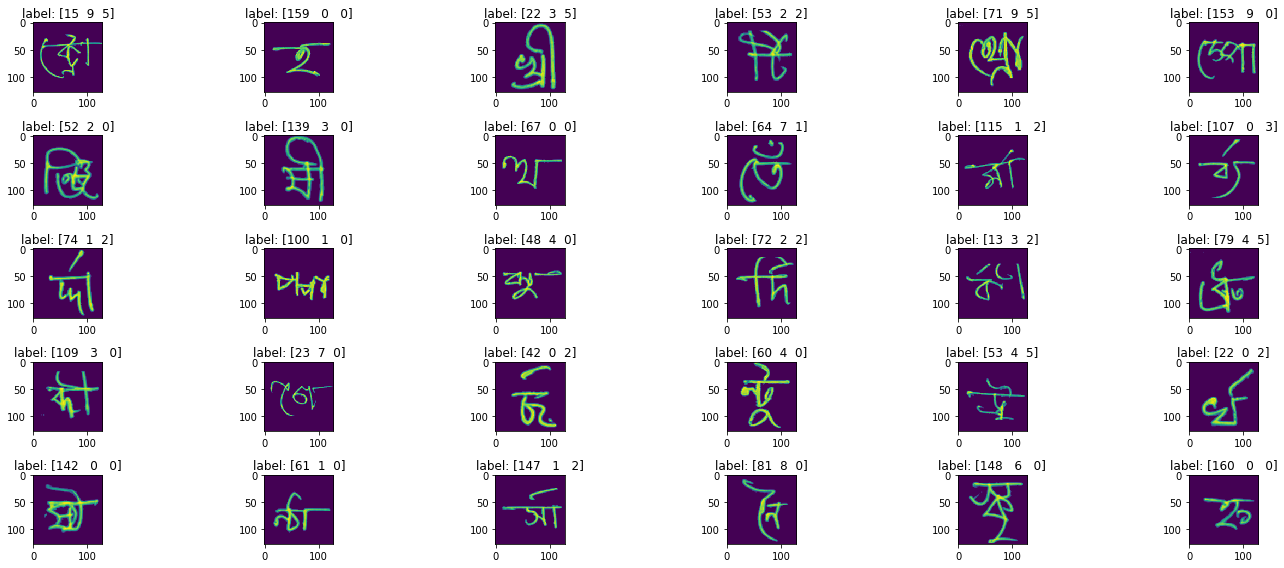

<Figure size 432x288 with 0 Axes>

In [17]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_resize(image, thh = 80.0/255, thl=28.0/255)) #, cmap='Greys'
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [18]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import SimilarityTransform, AffineTransform, warp
import numpy as np
import math


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 20
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle)*np.pi/180.0

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle)*np.pi/180.0

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)
    
#     print("rot:{}, shear:{},tx:{},ty:{}".format(rot_angle,shear_angle, tx,ty))
    
    shape = img.shape
    shape_size = shape[:2]
    center = np.float32(shape_size) / 2.
        
    pre = SimilarityTransform(translation=-center)
    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle, translation=(tx,ty)) 
    after = AffineTransform(translation=center)
    total_transform = pre+tform+after
#     total_transform = tform
    transformed_image = warp(img, total_transform.params, mode='constant')
    
    assert transformed_image.ndim == 2
    return transformed_image

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_char_image_thin(image, threshold=40./255., pad = 16):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def crop_char_image(img0, threshold=80./255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > threshold)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return img

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

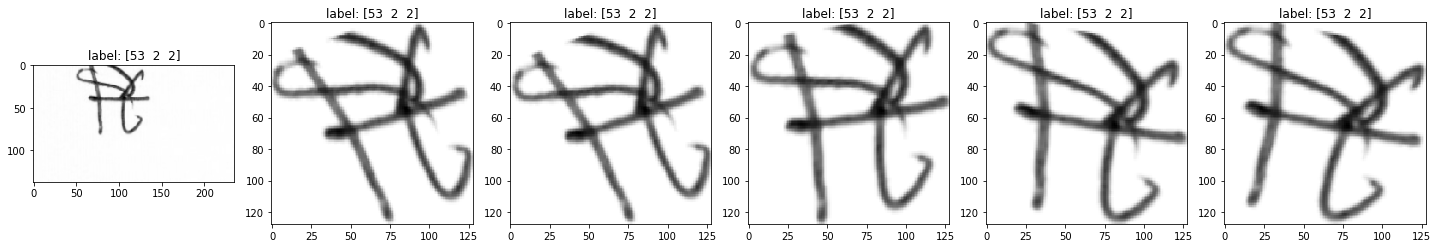

In [19]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[3]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    else:
        ax.imshow(resize(crop_char_image_thin(affine_image(crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
# crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

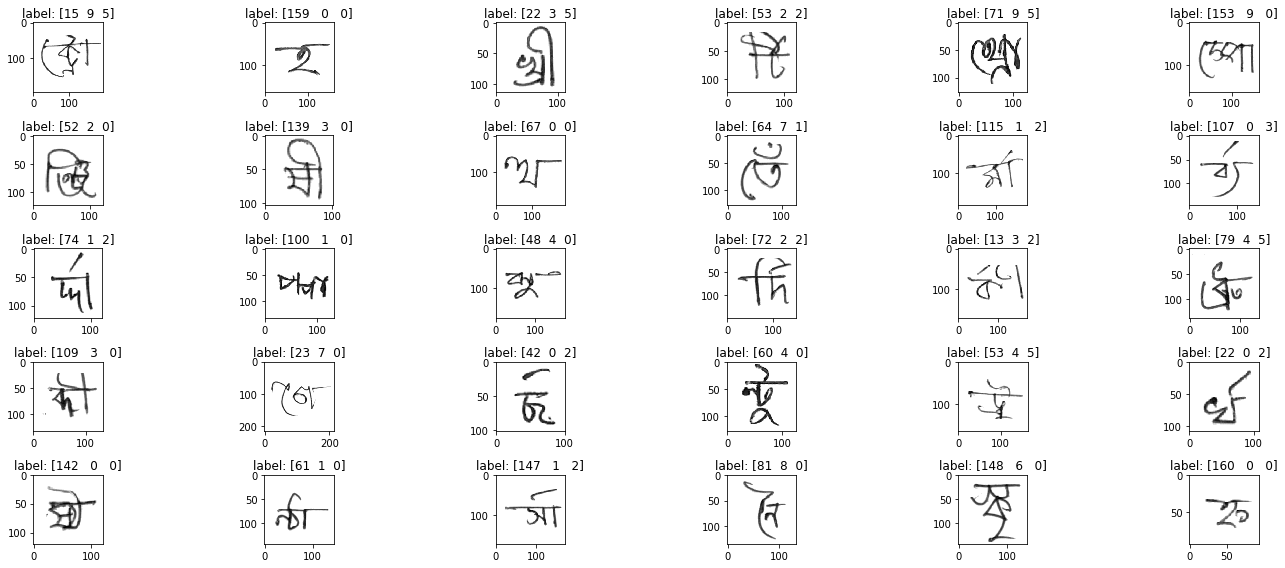

In [20]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_char_image(image, threshold=80./255.), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

whole process: crop_Char_imgage->affine->crop_char_image_thin->resize

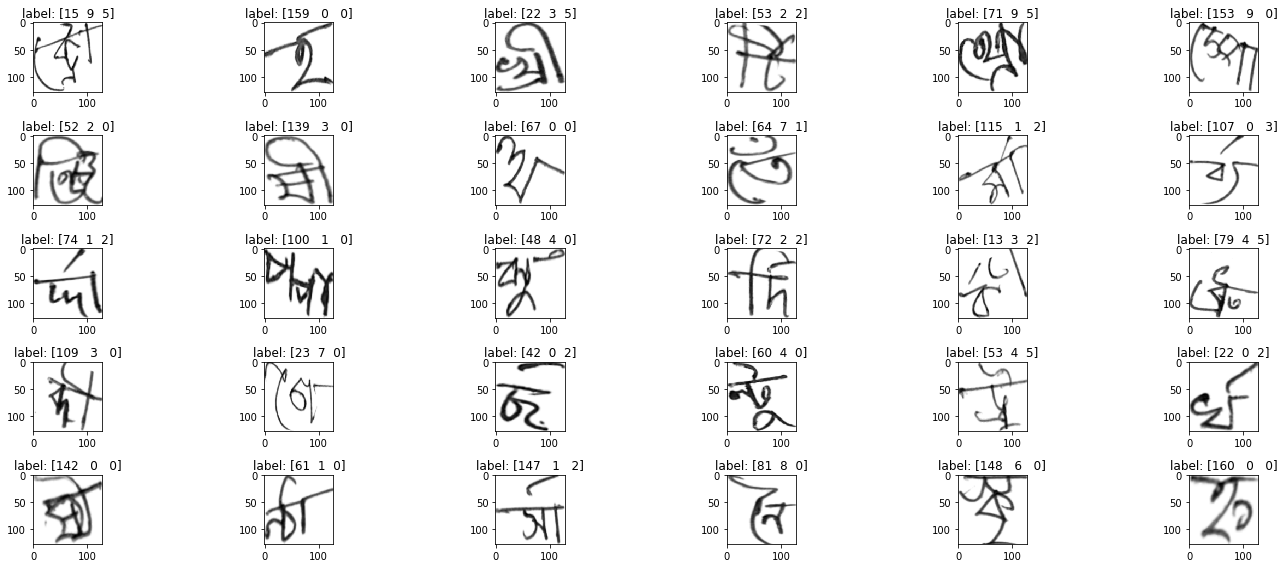

In [21]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(resize(crop_char_image_thin(affine_image((crop_char_image(image, threshold=100./255.))))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [22]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']

TH = 80.0

class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=TH,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
            
        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
            
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
            
        if self.crop:
            x = crop_char_image_thin(x, threshold=self.threshold/2)        
            
        if self.size is not None:
            x = resize(x, size=self.size)
            


        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
#            x = apply_aug(A.Cutout(num_holes=1,  max_h_size=16, max_w_size=16, p=1.0),x)  # Deprecated...
             x = apply_aug(A.CoarseDropout(max_holes=3, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=20,
                p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [23]:
train_transform = Transform(
    size=(image_size, image_size), 
    sigma=-1., blur_ratio=0.2, noise_ratio=0.1, cutout_ratio=0.5,
    grid_distortion_ratio=0.1, random_brightness_ratio=0.2,
    piece_affine_ratio=0.1, ssr_ratio=0.2, elastic_distortion_ratio=0.1) #threshold=20.,
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images[:200], train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

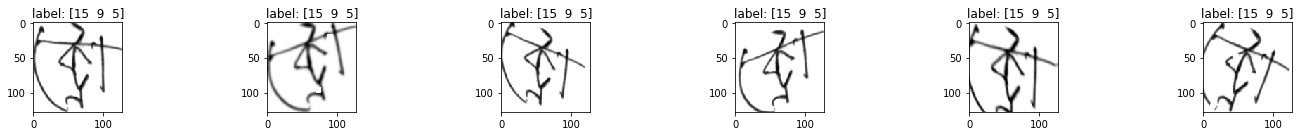

In [24]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 2))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[0]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

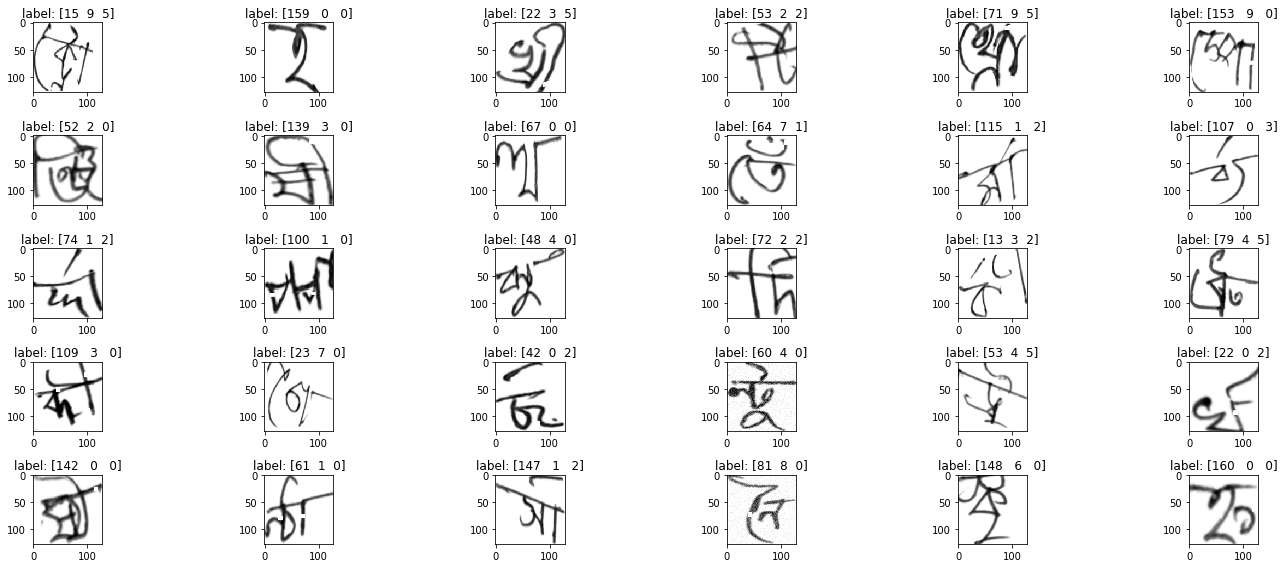

In [25]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [26]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [27]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [28]:
a = np.array([2,3])
b = np.array([4,5,6])

In [29]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [30]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [31]:
a = torch.Tensor([[1,2],[3,4]])
b = torch.sum(a,dim=(-1,-2))
print(b)

tensor(10.)


In [32]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = self.conv0(x)
        h = self.base_model.features(h)

        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
        return h

## Classifier

In [33]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


<a id="train"></a>
# Training code


In [34]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

def schedule_lr(metrics):
    avg_mae = metrics['loss']
    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

n_total 186


## prepare data

In [35]:
from logging import getLogger
import numpy
import os
from time import perf_counter
import argparse
from distutils.util import strtobool
import torch
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

import pandas as pd
import torch
import json


def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


In [36]:
class LogReport:
    def __init__(self, dirpath=None, logger=None):
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, epoch, iteration, train_metrics, val_metrics, mode):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': epoch,
                'iteration': iteration}
        
        elem.update({f'train/{key}': value
                     for key, value in train_metrics.items()})
        
        elem.update({f'val/{key}': value
             for key, value in val_metrics.items()})
        
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
#         print("mode in log type:{}, val:{}".format(type(mode), mode))
        elem['mode'] = str(mode)
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            elif isinstance(value, str):
                msg += f'{key} {value} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df

In [37]:
class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self):
        self.count += 1
        filepath = self.filepath.format(count=self.count)
        torch.save(self.model.state_dict(), filepath)

In [38]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [39]:
loss_recall_names =  ['loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'recall']

In [40]:
def train_model(epoch, data_loader, log_report, n_train_call):
    classifier.train()
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    n_tag = 0
    for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
        n_sub = img_batch.shape[0]
        img_batch = img_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        loss, metrics, pred_y = classifier(img_batch, regr_batch)
        
        recall = macro_recall(pred_y, regr_batch)
        metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
        for key, val in metrics.items():
                metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)
                
        n_tag = n_tag + n_sub
        n_train_call[0] += n_sub
        
        loss.backward()
        optimizer.step()
        
    schedule_lr(metrics_total)
    return metrics_total, n_train_call

In [41]:
def evaluate_model(epoch, data_loader, log_report):
    classifier.eval()
    n_tag = 0
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    with torch.no_grad():
        for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
            n_sub = img_batch.shape[0]
            img_batch = img_batch.to(device)
            regr_batch = regr_batch.to(device)

            _, metrics, pred_y = classifier(img_batch, regr_batch)
        
            recall = macro_recall(pred_y, regr_batch)
            metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
            for key, val in metrics.items():
                    metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)

            n_tag = n_tag + n_sub
    
        return metrics_total


## Train


In [48]:
def save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall, outdir):
    mode = list("000")
    if((epoch+1)%10==0):
        model_file_name = os.path.join(outdir, 'predictor_{}_{}.pt'.format(l1,epoch))
        torch.save(predictor.state_dict(), model_file_name)
        mode[0] = "1"
    if(val_metrics['loss']<min_val_loss):
        min_val_loss = val_metrics['loss']
        if mode[0] is "0":
            model_file_name = os.path.join(outdir, 'predictor_min_loss.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[1] = "1"
    if(val_metrics['recall']>max_val_recall):
        max_val_recall = val_metrics['recall']
        if mode[0] is not "1" and mode[1] is not "1":
            model_file_name = os.path.join(outdir, 'predictor_max_recall.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[2] = "1"
    mode = ''.join(mode)
    return mode, min_val_loss, max_val_recall

In [43]:
# mode = list("000")
# mode = ''.join(mode)
# print(mode)
# msg = ''
# key ="mode"
# value = mode
# msg += f'{key} {value}' 
# print(msg)

In [44]:
# import gc

# train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
# n_epochs = 50
# log_report = LogReport(dirpath=outdir)
# n_train_call = [0]
# min_val_loss = 1e10
# max_val_recall = 0

# for l1 in range(4):
# #     print(l1)
#     indices = [l1] #if debug else [0, 1, 2, 3]
#     train_images = prepare_image(
#         datadir, featherdir, data_type='train', submission=False, indices=indices)
#     each_part_num = 50210
#     train_labels = train_labels_total[(l1*each_part_num):((l1+1)*each_part_num)]
    
#     n_dataset = len(train_images)
#     train_data_size = 200 if debug else int(n_dataset * 0.9)
#     valid_data_size = 100 if debug else int(n_dataset - train_data_size)

#     perm = np.random.RandomState(777).permutation(n_dataset)
#     train_dataset = BengaliAIDataset(
#         train_images, train_labels, transform=Transform(size=(image_size, image_size)),
#         indices=perm[:train_data_size])
#     valid_dataset = BengaliAIDataset(
#         train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
#         indices=perm[train_data_size:train_data_size+valid_data_size])
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
#     valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
#     for epoch in range(n_epochs):
#         torch.cuda.empty_cache()
#         gc.collect()
#         train_metrics = train_model(epoch, train_loader, log_report)
#         val_metrics = evaluate_model(epoch, valid_loader, log_report)
#         mode, min_val_loss, max_val_recall = save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall)
# #         print("min_val_loss = ", min_val_loss)
# #         print("max_val_recall = ", max_val_recall)
#         log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)            

In [45]:
# import os
# a = "."
# b = os.path.join(a,"{}_fold".format(2))
# if not os.path.exists(b):
#     os.mkdir(b)
# print(b)
# c = os.path.join(b, 'log.json')
# print(c)

In [46]:
def save_params(outdir, k, img_size, th, arch):
    save_json(os.path.join(outdir, 'args_{}.json'.format(k)), 
              {'image_size': img_size, 
               'threshold': th, 
               'arch': arch, 
               'model_name': 'se_resnext50_32x4d'}
             )

In [52]:
import gc

train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
n_epochs = 40
kfold = 5

for k in range(kfold):
    # Set pretrained='imagenet' to download imagenet pretrained model...
    predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
    print('predictor', type(predictor))

    classifier = BengaliClassifier(predictor).to(device)

    # --- Training setting ---
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-10)

    sub_dir = os.path.join(outdir,"{}_fold".format(k))
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    log_report = LogReport(dirpath=sub_dir)
    n_train_call = [0]
    min_val_loss = 1e10
    max_val_recall = 0
    val_indexes = train[train['fold']==k].index.tolist()
    train_indexes = train[train['fold']!=k].index.tolist()
    save_params(outdir, k, image_size, TH, arch)
    if debug:
        val_indexes = val_indexes[:100]
        train_indexes = train_indexes[:200]
        print("val_indexes:", val_indexes[:5])
        print("train_indexes:", train_indexes[:5])
        
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(size=(image_size, image_size)),
        indices=train_indexes)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        indices=val_indexes)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        gc.collect()
        train_metrics, n_train_call = train_model(epoch, train_loader, log_report, n_train_call)
        val_metrics = evaluate_model(epoch, valid_loader, log_report)
        mode, min_val_loss, max_val_recall = save_res(predictor, k, epoch, val_metrics, min_val_loss, max_val_recall, sub_dir)
#         print("mode type:{}, mode val:{}".format(type(mode), mode))
#         print("min_val_loss = ", min_val_loss)
#         print("max_val_recall = ", max_val_recall)
        log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode) 

predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      0 train/loss  2.979984 train/loss_grapheme  2.017329 train/loss_vowel  0.507406 train/loss_consonant  0.455248 train/acc_grapheme  0.564330 train/acc_vowel  0.876961 train/acc_consonant  0.886178 train/recall  0.635996 val/loss  0.790211 val/loss_grapheme  0.504717 val/loss_vowel  0.144112 val/loss_consonant  0.141382 val/acc_grapheme  0.873506 val/acc_vowel  0.964275 val/acc_consonant  0.959719 val/recall  0.868977 lr  0.001000 elapsed_time  1352.173442 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      1 train/loss  0.939093 train/loss_grapheme  0.629257 train/loss_vowel  0.165087 train/loss_consonant  0.144749 train/acc_grapheme  0.853914 train/acc_vowel  0.958057 train/acc_consonant  0.959246 train/recall  0.855434 val/loss  0.523345 val/loss_grapheme  0.339397 val/loss_vowel  0.094330 val/loss_consonant  0.089617 val/acc_grapheme  0.915555 val/acc_vowel  0.975951 val/acc_consonant  0.974407 val/recall  0.909474 lr  0.001000 elapsed_time  2705.083907 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      2 train/loss  0.657405 train/loss_grapheme  0.429707 train/loss_vowel  0.119028 train/loss_consonant  0.108670 train/acc_grapheme  0.894730 train/acc_vowel  0.969640 train/acc_consonant  0.969379 train/recall  0.892652 val/loss  0.465267 val/loss_grapheme  0.295245 val/loss_vowel  0.085587 val/loss_consonant  0.084435 val/acc_grapheme  0.926359 val/acc_vowel  0.978067 val/acc_consonant  0.976001 val/recall  0.918581 lr  0.001000 elapsed_time  4058.546406 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      3 train/loss  0.524636 train/loss_grapheme  0.337410 train/loss_vowel  0.097848 train/loss_consonant  0.089378 train/acc_grapheme  0.913992 train/acc_vowel  0.975204 train/acc_consonant  0.974127 train/recall  0.911015 val/loss  0.400985 val/loss_grapheme  0.259753 val/loss_vowel  0.071747 val/loss_consonant  0.069485 val/acc_grapheme  0.936243 val/acc_vowel  0.981304 val/acc_consonant  0.979860 val/recall  0.930414 lr  0.001000 elapsed_time  5413.945716 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      4 train/loss  0.451905 train/loss_grapheme  0.289256 train/loss_vowel  0.085132 train/loss_consonant  0.077517 train/acc_grapheme  0.925046 train/acc_vowel  0.977899 train/acc_consonant  0.977968 train/recall  0.921434 val/loss  0.396095 val/loss_grapheme  0.253573 val/loss_vowel  0.068635 val/loss_consonant  0.073887 val/acc_grapheme  0.937214 val/acc_vowel  0.982922 val/acc_consonant  0.979138 val/recall  0.932383 lr  0.001000 elapsed_time  6762.067076 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      5 train/loss  0.399295 train/loss_grapheme  0.253771 train/loss_vowel  0.075069 train/loss_consonant  0.070455 train/acc_grapheme  0.932446 train/acc_vowel  0.980252 train/acc_consonant  0.979791 train/recall  0.928796 val/loss  0.371558 val/loss_grapheme  0.240696 val/loss_vowel  0.067153 val/loss_consonant  0.063709 val/acc_grapheme  0.941097 val/acc_vowel  0.983320 val/acc_consonant  0.981801 val/recall  0.935977 lr  0.001000 elapsed_time  8107.854617 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      6 train/loss  0.357896 train/loss_grapheme  0.227928 train/loss_vowel  0.067199 train/loss_consonant  0.062769 train/acc_grapheme  0.939411 train/acc_vowel  0.982250 train/acc_consonant  0.981976 train/recall  0.935825 val/loss  0.352452 val/loss_grapheme  0.223885 val/loss_vowel  0.063001 val/loss_consonant  0.065566 val/acc_grapheme  0.944533 val/acc_vowel  0.983494 val/acc_consonant  0.981677 val/recall  0.938955 lr  0.001000 elapsed_time  9458.737298 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      7 train/loss  0.333275 train/loss_grapheme  0.211364 train/loss_vowel  0.061857 train/loss_consonant  0.060055 train/acc_grapheme  0.942523 train/acc_vowel  0.983924 train/acc_consonant  0.982766 train/recall  0.939432 val/loss  0.355641 val/loss_grapheme  0.228739 val/loss_vowel  0.064938 val/loss_consonant  0.061964 val/acc_grapheme  0.942516 val/acc_vowel  0.983494 val/acc_consonant  0.982623 val/recall  0.937552 lr  0.001000 elapsed_time  10806.071184 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      8 train/loss  0.303109 train/loss_grapheme  0.191828 train/loss_vowel  0.057252 train/loss_consonant  0.054029 train/acc_grapheme  0.947651 train/acc_vowel  0.984826 train/acc_consonant  0.984565 train/recall  0.944179 val/loss  0.355381 val/loss_grapheme  0.228613 val/loss_vowel  0.063150 val/loss_consonant  0.063618 val/acc_grapheme  0.945404 val/acc_vowel  0.984415 val/acc_consonant  0.981752 val/recall  0.940304 lr  0.001000 elapsed_time  12153.642550 mode 001 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      9 train/loss  0.279208 train/loss_grapheme  0.176175 train/loss_vowel  0.052765 train/loss_consonant  0.050269 train/acc_grapheme  0.951821 train/acc_vowel  0.985710 train/acc_consonant  0.985722 train/recall  0.947957 val/loss  0.337205 val/loss_grapheme  0.218130 val/loss_vowel  0.060453 val/loss_consonant  0.058622 val/acc_grapheme  0.945554 val/acc_vowel  0.984117 val/acc_consonant  0.983768 val/recall  0.940753 lr  0.001000 elapsed_time  13497.947789 mode 111 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     10 train/loss  0.261793 train/loss_grapheme  0.165745 train/loss_vowel  0.048934 train/loss_consonant  0.047113 train/acc_grapheme  0.953887 train/acc_vowel  0.986556 train/acc_consonant  0.986115 train/recall  0.950702 val/loss  0.318607 val/loss_grapheme  0.203011 val/loss_vowel  0.060981 val/loss_consonant  0.054615 val/acc_grapheme  0.949562 val/acc_vowel  0.984913 val/acc_consonant  0.984216 val/recall  0.944472 lr  0.001000 elapsed_time  14845.028796 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     11 train/loss  0.248838 train/loss_grapheme  0.155552 train/loss_vowel  0.048177 train/loss_consonant  0.045110 train/acc_grapheme  0.955910 train/acc_vowel  0.986973 train/acc_consonant  0.987067 train/recall  0.952694 val/loss  0.313806 val/loss_grapheme  0.199168 val/loss_vowel  0.057459 val/loss_consonant  0.057179 val/acc_grapheme  0.950558 val/acc_vowel  0.985361 val/acc_consonant  0.984092 val/recall  0.945162 lr  0.001000 elapsed_time  16191.824997 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     12 train/loss  0.231693 train/loss_grapheme  0.146191 train/loss_vowel  0.043688 train/loss_consonant  0.041815 train/acc_grapheme  0.958649 train/acc_vowel  0.987801 train/acc_consonant  0.987789 train/recall  0.955274 val/loss  0.333746 val/loss_grapheme  0.210983 val/loss_vowel  0.060564 val/loss_consonant  0.062199 val/acc_grapheme  0.948690 val/acc_vowel  0.985063 val/acc_consonant  0.982698 val/recall  0.942389 lr  0.001000 elapsed_time  17537.771396 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     13 train/loss  0.222854 train/loss_grapheme  0.140477 train/loss_vowel  0.042831 train/loss_consonant  0.039547 train/acc_grapheme  0.960304 train/acc_vowel  0.988393 train/acc_consonant  0.988305 train/recall  0.957189 val/loss  0.316605 val/loss_grapheme  0.196676 val/loss_vowel  0.058287 val/loss_consonant  0.061641 val/acc_grapheme  0.951105 val/acc_vowel  0.985337 val/acc_consonant  0.983320 val/recall  0.946243 lr  0.001000 elapsed_time  18885.480090 mode 001 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     14 train/loss  0.208877 train/loss_grapheme  0.130656 train/loss_vowel  0.039938 train/loss_consonant  0.038283 train/acc_grapheme  0.962227 train/acc_vowel  0.988828 train/acc_consonant  0.988834 train/recall  0.959239 val/loss  0.327091 val/loss_grapheme  0.206484 val/loss_vowel  0.062751 val/loss_consonant  0.057856 val/acc_grapheme  0.949288 val/acc_vowel  0.984440 val/acc_consonant  0.984689 val/recall  0.945073 lr  0.001000 elapsed_time  20231.814776 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     15 train/loss  0.201372 train/loss_grapheme  0.126601 train/loss_vowel  0.038174 train/loss_consonant  0.036596 train/acc_grapheme  0.963373 train/acc_vowel  0.989052 train/acc_consonant  0.989065 train/recall  0.960300 val/loss  0.329484 val/loss_grapheme  0.207002 val/loss_vowel  0.063246 val/loss_consonant  0.059235 val/acc_grapheme  0.951080 val/acc_vowel  0.984963 val/acc_consonant  0.984142 val/recall  0.945665 lr  0.001000 elapsed_time  21581.238283 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     16 train/loss  0.191293 train/loss_grapheme  0.119357 train/loss_vowel  0.036473 train/loss_consonant  0.035463 train/acc_grapheme  0.965258 train/acc_vowel  0.989668 train/acc_consonant  0.989805 train/recall  0.962299 val/loss  0.314111 val/loss_grapheme  0.199734 val/loss_vowel  0.056703 val/loss_consonant  0.057673 val/acc_grapheme  0.951080 val/acc_vowel  0.986631 val/acc_consonant  0.984714 val/recall  0.946344 lr  0.001000 elapsed_time  22930.617647 mode 001 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     17 train/loss  0.184935 train/loss_grapheme  0.116269 train/loss_vowel  0.033766 train/loss_consonant  0.034900 train/acc_grapheme  0.966061 train/acc_vowel  0.990372 train/acc_consonant  0.989637 train/recall  0.963194 val/loss  0.316366 val/loss_grapheme  0.196925 val/loss_vowel  0.059579 val/loss_consonant  0.059862 val/acc_grapheme  0.951255 val/acc_vowel  0.986059 val/acc_consonant  0.984739 val/recall  0.947022 lr  0.001000 elapsed_time  24280.879925 mode 001 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     18 train/loss  0.179860 train/loss_grapheme  0.112015 train/loss_vowel  0.034151 train/loss_consonant  0.033693 train/acc_grapheme  0.967175 train/acc_vowel  0.990054 train/acc_consonant  0.989724 train/recall  0.964472 val/loss  0.317764 val/loss_grapheme  0.199868 val/loss_vowel  0.060106 val/loss_consonant  0.057790 val/acc_grapheme  0.953670 val/acc_vowel  0.985785 val/acc_consonant  0.984888 val/recall  0.948729 lr  0.001000 elapsed_time  25629.589514 mode 001 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     19 train/loss  0.172521 train/loss_grapheme  0.107298 train/loss_vowel  0.033134 train/loss_consonant  0.032089 train/acc_grapheme  0.968893 train/acc_vowel  0.990540 train/acc_consonant  0.990465 train/recall  0.966009 val/loss  0.330602 val/loss_grapheme  0.205249 val/loss_vowel  0.063595 val/loss_consonant  0.061758 val/acc_grapheme  0.952300 val/acc_vowel  0.984988 val/acc_consonant  0.984042 val/recall  0.947450 lr  0.001000 elapsed_time  26977.462347 mode 100 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     20 train/loss  0.165730 train/loss_grapheme  0.103641 train/loss_vowel  0.031483 train/loss_consonant  0.030606 train/acc_grapheme  0.969696 train/acc_vowel  0.990857 train/acc_consonant  0.990534 train/recall  0.966905 val/loss  0.311914 val/loss_grapheme  0.196302 val/loss_vowel  0.057835 val/loss_consonant  0.057777 val/acc_grapheme  0.953744 val/acc_vowel  0.986880 val/acc_consonant  0.985486 val/recall  0.949732 lr  0.001000 elapsed_time  28326.189838 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     21 train/loss  0.159185 train/loss_grapheme  0.099729 train/loss_vowel  0.029898 train/loss_consonant  0.029557 train/acc_grapheme  0.970150 train/acc_vowel  0.991199 train/acc_consonant  0.991143 train/recall  0.967188 val/loss  0.333765 val/loss_grapheme  0.206833 val/loss_vowel  0.063896 val/loss_consonant  0.063037 val/acc_grapheme  0.950856 val/acc_vowel  0.985486 val/acc_consonant  0.983345 val/recall  0.945403 lr  0.001000 elapsed_time  29670.275929 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     22 train/loss  0.155696 train/loss_grapheme  0.096738 train/loss_vowel  0.029424 train/loss_consonant  0.029534 train/acc_grapheme  0.971563 train/acc_vowel  0.991654 train/acc_consonant  0.990832 train/recall  0.968711 val/loss  0.334735 val/loss_grapheme  0.207969 val/loss_vowel  0.065380 val/loss_consonant  0.061386 val/acc_grapheme  0.950906 val/acc_vowel  0.985013 val/acc_consonant  0.983793 val/recall  0.945955 lr  0.001000 elapsed_time  31017.206645 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     23 train/loss  0.151884 train/loss_grapheme  0.095056 train/loss_vowel  0.029051 train/loss_consonant  0.027777 train/acc_grapheme  0.971545 train/acc_vowel  0.991343 train/acc_consonant  0.991224 train/recall  0.968789 val/loss  0.334676 val/loss_grapheme  0.204360 val/loss_vowel  0.065794 val/loss_consonant  0.064523 val/acc_grapheme  0.951877 val/acc_vowel  0.984391 val/acc_consonant  0.983370 val/recall  0.946499 lr  0.001000 elapsed_time  32359.922908 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     24 train/loss  0.146577 train/loss_grapheme  0.091943 train/loss_vowel  0.027140 train/loss_consonant  0.027494 train/acc_grapheme  0.972609 train/acc_vowel  0.992033 train/acc_consonant  0.991629 train/recall  0.970132 val/loss  0.327726 val/loss_grapheme  0.201819 val/loss_vowel  0.064586 val/loss_consonant  0.061321 val/acc_grapheme  0.951703 val/acc_vowel  0.984590 val/acc_consonant  0.984391 val/recall  0.946407 lr  0.001000 elapsed_time  33703.337569 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     25 train/loss  0.142600 train/loss_grapheme  0.089005 train/loss_vowel  0.026800 train/loss_consonant  0.026795 train/acc_grapheme  0.973225 train/acc_vowel  0.991859 train/acc_consonant  0.991567 train/recall  0.970655 val/loss  0.341454 val/loss_grapheme  0.212247 val/loss_vowel  0.064540 val/loss_consonant  0.064667 val/acc_grapheme  0.949811 val/acc_vowel  0.985586 val/acc_consonant  0.984042 val/recall  0.945617 lr  0.001000 elapsed_time  35053.914622 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     26 train/loss  0.139267 train/loss_grapheme  0.087651 train/loss_vowel  0.025977 train/loss_consonant  0.025639 train/acc_grapheme  0.973984 train/acc_vowel  0.992233 train/acc_consonant  0.992065 train/recall  0.971373 val/loss  0.332816 val/loss_grapheme  0.203711 val/loss_vowel  0.064999 val/loss_consonant  0.064106 val/acc_grapheme  0.952275 val/acc_vowel  0.984839 val/acc_consonant  0.983121 val/recall  0.945765 lr  0.001000 elapsed_time  36405.257225 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     27 train/loss  0.140134 train/loss_grapheme  0.088268 train/loss_vowel  0.026395 train/loss_consonant  0.025472 train/acc_grapheme  0.973567 train/acc_vowel  0.992121 train/acc_consonant  0.992089 train/recall  0.970965 val/loss  0.335201 val/loss_grapheme  0.200843 val/loss_vowel  0.068905 val/loss_consonant  0.065454 val/acc_grapheme  0.952724 val/acc_vowel  0.984167 val/acc_consonant  0.983967 val/recall  0.946871 lr  0.001000 elapsed_time  37750.188052 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     28 train/loss  0.134141 train/loss_grapheme  0.084067 train/loss_vowel  0.025518 train/loss_consonant  0.024555 train/acc_grapheme  0.974700 train/acc_vowel  0.992562 train/acc_consonant  0.992270 train/recall  0.972327 val/loss  0.340347 val/loss_grapheme  0.211777 val/loss_vowel  0.066423 val/loss_consonant  0.062148 val/acc_grapheme  0.950134 val/acc_vowel  0.985137 val/acc_consonant  0.984341 val/recall  0.945360 lr  0.001000 elapsed_time  39098.117416 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     29 train/loss  0.131849 train/loss_grapheme  0.081577 train/loss_vowel  0.025249 train/loss_consonant  0.025023 train/acc_grapheme  0.975372 train/acc_vowel  0.992699 train/acc_consonant  0.992096 train/recall  0.972745 val/loss  0.326918 val/loss_grapheme  0.202730 val/loss_vowel  0.063492 val/loss_consonant  0.060697 val/acc_grapheme  0.953570 val/acc_vowel  0.985959 val/acc_consonant  0.985411 val/recall  0.949047 lr  0.001000 elapsed_time  40442.949170 mode 100 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     30 train/loss  0.130423 train/loss_grapheme  0.079707 train/loss_vowel  0.026381 train/loss_consonant  0.024334 train/acc_grapheme  0.975988 train/acc_vowel  0.992220 train/acc_consonant  0.992363 train/recall  0.973293 val/loss  0.343579 val/loss_grapheme  0.219318 val/loss_vowel  0.064073 val/loss_consonant  0.060188 val/acc_grapheme  0.950334 val/acc_vowel  0.985162 val/acc_consonant  0.984316 val/recall  0.945606 lr  0.001000 elapsed_time  41788.493809 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     31 train/loss  0.130021 train/loss_grapheme  0.081024 train/loss_vowel  0.024938 train/loss_consonant  0.024059 train/acc_grapheme  0.975403 train/acc_vowel  0.992407 train/acc_consonant  0.992382 train/recall  0.972859 val/loss  0.319887 val/loss_grapheme  0.194167 val/loss_vowel  0.065225 val/loss_consonant  0.060495 val/acc_grapheme  0.955338 val/acc_vowel  0.985212 val/acc_consonant  0.984789 val/recall  0.950364 lr  0.001000 elapsed_time  43133.743158 mode 001 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     32 train/loss  0.128201 train/loss_grapheme  0.079346 train/loss_vowel  0.024988 train/loss_consonant  0.023868 train/acc_grapheme  0.975839 train/acc_vowel  0.992357 train/acc_consonant  0.992208 train/recall  0.973323 val/loss  0.324306 val/loss_grapheme  0.194651 val/loss_vowel  0.066005 val/loss_consonant  0.063651 val/acc_grapheme  0.953694 val/acc_vowel  0.984938 val/acc_consonant  0.984042 val/recall  0.948003 lr  0.001000 elapsed_time  44474.540066 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     33 train/loss  0.120244 train/loss_grapheme  0.074318 train/loss_vowel  0.023150 train/loss_consonant  0.022776 train/acc_grapheme  0.977551 train/acc_vowel  0.992998 train/acc_consonant  0.992525 train/recall  0.975223 val/loss  0.328322 val/loss_grapheme  0.201067 val/loss_vowel  0.066294 val/loss_consonant  0.060961 val/acc_grapheme  0.951753 val/acc_vowel  0.985063 val/acc_consonant  0.985337 val/recall  0.947350 lr  0.001000 elapsed_time  45817.139221 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     34 train/loss  0.122273 train/loss_grapheme  0.074951 train/loss_vowel  0.023897 train/loss_consonant  0.023426 train/acc_grapheme  0.977071 train/acc_vowel  0.992631 train/acc_consonant  0.992699 train/recall  0.974609 val/loss  0.330806 val/loss_grapheme  0.200987 val/loss_vowel  0.064022 val/loss_consonant  0.065797 val/acc_grapheme  0.955188 val/acc_vowel  0.985287 val/acc_consonant  0.984117 val/recall  0.949050 lr  0.001000 elapsed_time  47164.290763 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     35 train/loss  0.120817 train/loss_grapheme  0.075180 train/loss_vowel  0.023266 train/loss_consonant  0.022371 train/acc_grapheme  0.977246 train/acc_vowel  0.992805 train/acc_consonant  0.992774 train/recall  0.974741 val/loss  0.340280 val/loss_grapheme  0.206573 val/loss_vowel  0.066686 val/loss_consonant  0.067020 val/acc_grapheme  0.952873 val/acc_vowel  0.985411 val/acc_consonant  0.983345 val/recall  0.947528 lr  0.001000 elapsed_time  48511.991646 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     36 train/loss  0.118775 train/loss_grapheme  0.073187 train/loss_vowel  0.023545 train/loss_consonant  0.022043 train/acc_grapheme  0.977208 train/acc_vowel  0.992743 train/acc_consonant  0.993011 train/recall  0.974832 val/loss  0.345214 val/loss_grapheme  0.215915 val/loss_vowel  0.065169 val/loss_consonant  0.064130 val/acc_grapheme  0.951205 val/acc_vowel  0.985511 val/acc_consonant  0.984615 val/recall  0.946610 lr  0.001000 elapsed_time  49862.322161 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     37 train/loss  0.115597 train/loss_grapheme  0.071025 train/loss_vowel  0.022470 train/loss_consonant  0.022102 train/acc_grapheme  0.978024 train/acc_vowel  0.993359 train/acc_consonant  0.993166 train/recall  0.976120 val/loss  0.350559 val/loss_grapheme  0.214746 val/loss_vowel  0.070257 val/loss_consonant  0.065556 val/acc_grapheme  0.951105 val/acc_vowel  0.984864 val/acc_consonant  0.983644 val/recall  0.946080 lr  0.001000 elapsed_time  51216.790068 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     38 train/loss  0.113412 train/loss_grapheme  0.069242 train/loss_vowel  0.022254 train/loss_consonant  0.021916 train/acc_grapheme  0.978577 train/acc_vowel  0.993228 train/acc_consonant  0.992979 train/recall  0.976061 val/loss  0.347011 val/loss_grapheme  0.212574 val/loss_vowel  0.070213 val/loss_consonant  0.064225 val/acc_grapheme  0.950881 val/acc_vowel  0.984341 val/acc_consonant  0.983843 val/recall  0.945346 lr  0.001000 elapsed_time  52573.628944 mode 000 


100%|██████████| 1256/1256 [01:57<00:00, 10.68it/s]


epoch     39 train/loss  0.114291 train/loss_grapheme  0.069870 train/loss_vowel  0.023259 train/loss_consonant  0.021162 train/acc_grapheme  0.978658 train/acc_vowel  0.992805 train/acc_consonant  0.993334 train/recall  0.976454 val/loss  0.345179 val/loss_grapheme  0.214348 val/loss_vowel  0.066553 val/loss_consonant  0.064278 val/acc_grapheme  0.950433 val/acc_vowel  0.984640 val/acc_consonant  0.984216 val/recall  0.944594 lr  0.001000 elapsed_time  53927.847426 mode 100 
predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      0 train/loss  2.977995 train/loss_grapheme  1.990757 train/loss_vowel  0.527581 train/loss_consonant  0.459657 train/acc_grapheme  0.568475 train/acc_vowel  0.874882 train/acc_consonant  0.887292 train/recall  0.637332 val/loss  0.810240 val/loss_grapheme  0.506439 val/loss_vowel  0.158677 val/loss_consonant  0.145125 val/acc_grapheme  0.872635 val/acc_vowel  0.958972 val/acc_consonant  0.962109 val/recall  0.866758 lr  0.001000 elapsed_time  1361.714436 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      1 train/loss  0.944040 train/loss_grapheme  0.630506 train/loss_vowel  0.166673 train/loss_consonant  0.146862 train/acc_grapheme  0.852719 train/acc_vowel  0.958530 train/acc_consonant  0.958649 train/recall  0.853889 val/loss  0.546216 val/loss_grapheme  0.352047 val/loss_vowel  0.100559 val/loss_consonant  0.093610 val/acc_grapheme  0.910874 val/acc_vowel  0.973885 val/acc_consonant  0.972764 val/recall  0.906502 lr  0.001000 elapsed_time  2728.397411 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      2 train/loss  0.657106 train/loss_grapheme  0.430800 train/loss_vowel  0.119491 train/loss_consonant  0.106816 train/acc_grapheme  0.893653 train/acc_vowel  0.969572 train/acc_consonant  0.969030 train/recall  0.891575 val/loss  0.439956 val/loss_grapheme  0.281095 val/loss_vowel  0.083988 val/loss_consonant  0.074873 val/acc_grapheme  0.930517 val/acc_vowel  0.977644 val/acc_consonant  0.978938 val/recall  0.924681 lr  0.001000 elapsed_time  4089.158873 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      3 train/loss  0.529742 train/loss_grapheme  0.341191 train/loss_vowel  0.098276 train/loss_consonant  0.090275 train/acc_grapheme  0.913600 train/acc_vowel  0.975036 train/acc_consonant  0.974152 train/recall  0.910609 val/loss  0.383290 val/loss_grapheme  0.253393 val/loss_vowel  0.067083 val/loss_consonant  0.062814 val/acc_grapheme  0.937512 val/acc_vowel  0.982822 val/acc_consonant  0.982523 val/recall  0.932734 lr  0.001000 elapsed_time  5449.967605 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      4 train/loss  0.457446 train/loss_grapheme  0.292168 train/loss_vowel  0.086698 train/loss_consonant  0.078581 train/acc_grapheme  0.924642 train/acc_vowel  0.977681 train/acc_consonant  0.977457 train/recall  0.920657 val/loss  0.366734 val/loss_grapheme  0.235916 val/loss_vowel  0.065086 val/loss_consonant  0.065732 val/acc_grapheme  0.940102 val/acc_vowel  0.983270 val/acc_consonant  0.981453 val/recall  0.933916 lr  0.001000 elapsed_time  6806.805663 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      5 train/loss  0.404345 train/loss_grapheme  0.258153 train/loss_vowel  0.075432 train/loss_consonant  0.070759 train/acc_grapheme  0.932701 train/acc_vowel  0.980563 train/acc_consonant  0.979530 train/recall  0.928983 val/loss  0.350974 val/loss_grapheme  0.228343 val/loss_vowel  0.063416 val/loss_consonant  0.059216 val/acc_grapheme  0.942890 val/acc_vowel  0.983320 val/acc_consonant  0.983544 val/recall  0.936552 lr  0.001000 elapsed_time  8165.539453 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      6 train/loss  0.360404 train/loss_grapheme  0.228154 train/loss_vowel  0.067806 train/loss_consonant  0.064443 train/acc_grapheme  0.939691 train/acc_vowel  0.982480 train/acc_consonant  0.981440 train/recall  0.936098 val/loss  0.337740 val/loss_grapheme  0.219919 val/loss_vowel  0.057906 val/loss_consonant  0.059916 val/acc_grapheme  0.943587 val/acc_vowel  0.984739 val/acc_consonant  0.983793 val/recall  0.938531 lr  0.001000 elapsed_time  9527.511396 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      7 train/loss  0.329903 train/loss_grapheme  0.209686 train/loss_vowel  0.061931 train/loss_consonant  0.058286 train/acc_grapheme  0.943394 train/acc_vowel  0.983619 train/acc_consonant  0.983270 train/recall  0.939373 val/loss  0.328264 val/loss_grapheme  0.217667 val/loss_vowel  0.055981 val/loss_consonant  0.054615 val/acc_grapheme  0.946151 val/acc_vowel  0.985212 val/acc_consonant  0.984789 val/recall  0.941430 lr  0.001000 elapsed_time  10884.762944 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      8 train/loss  0.305635 train/loss_grapheme  0.192786 train/loss_vowel  0.058287 train/loss_consonant  0.054563 train/acc_grapheme  0.947066 train/acc_vowel  0.984808 train/acc_consonant  0.984254 train/recall  0.943337 val/loss  0.324700 val/loss_grapheme  0.213345 val/loss_vowel  0.057394 val/loss_consonant  0.053961 val/acc_grapheme  0.947720 val/acc_vowel  0.985038 val/acc_consonant  0.984689 val/recall  0.941922 lr  0.001000 elapsed_time  12241.957798 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      9 train/loss  0.280256 train/loss_grapheme  0.177353 train/loss_vowel  0.052492 train/loss_consonant  0.050410 train/acc_grapheme  0.950975 train/acc_vowel  0.985891 train/acc_consonant  0.985461 train/recall  0.947841 val/loss  0.312866 val/loss_grapheme  0.199679 val/loss_vowel  0.053441 val/loss_consonant  0.059747 val/acc_grapheme  0.950458 val/acc_vowel  0.985237 val/acc_consonant  0.983519 val/recall  0.943569 lr  0.001000 elapsed_time  13602.913255 mode 111 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     10 train/loss  0.265129 train/loss_grapheme  0.166796 train/loss_vowel  0.050485 train/loss_consonant  0.047848 train/acc_grapheme  0.953576 train/acc_vowel  0.985996 train/acc_consonant  0.986059 train/recall  0.949950 val/loss  0.323790 val/loss_grapheme  0.205018 val/loss_vowel  0.058227 val/loss_consonant  0.060545 val/acc_grapheme  0.949836 val/acc_vowel  0.985386 val/acc_consonant  0.983121 val/recall  0.943826 lr  0.001000 elapsed_time  14959.660325 mode 001 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     11 train/loss  0.248163 train/loss_grapheme  0.156454 train/loss_vowel  0.046937 train/loss_consonant  0.044772 train/acc_grapheme  0.956190 train/acc_vowel  0.987222 train/acc_consonant  0.986712 train/recall  0.953004 val/loss  0.317343 val/loss_grapheme  0.206698 val/loss_vowel  0.056996 val/loss_consonant  0.053649 val/acc_grapheme  0.947993 val/acc_vowel  0.985162 val/acc_consonant  0.985337 val/recall  0.943156 lr  0.001000 elapsed_time  16325.145778 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     12 train/loss  0.234658 train/loss_grapheme  0.146283 train/loss_vowel  0.045552 train/loss_consonant  0.042823 train/acc_grapheme  0.958568 train/acc_vowel  0.987583 train/acc_consonant  0.987459 train/recall  0.955287 val/loss  0.309291 val/loss_grapheme  0.197476 val/loss_vowel  0.056127 val/loss_consonant  0.055688 val/acc_grapheme  0.950832 val/acc_vowel  0.986059 val/acc_consonant  0.984913 val/recall  0.944955 lr  0.001000 elapsed_time  17692.727108 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     13 train/loss  0.222981 train/loss_grapheme  0.139587 train/loss_vowel  0.042096 train/loss_consonant  0.041298 train/acc_grapheme  0.960802 train/acc_vowel  0.988573 train/acc_consonant  0.987832 train/recall  0.957400 val/loss  0.304190 val/loss_grapheme  0.191102 val/loss_vowel  0.055917 val/loss_consonant  0.057171 val/acc_grapheme  0.953246 val/acc_vowel  0.986332 val/acc_consonant  0.984590 val/recall  0.947749 lr  0.001000 elapsed_time  19061.826998 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     14 train/loss  0.211898 train/loss_grapheme  0.132409 train/loss_vowel  0.040808 train/loss_consonant  0.038681 train/acc_grapheme  0.962395 train/acc_vowel  0.988641 train/acc_consonant  0.988399 train/recall  0.958714 val/loss  0.314903 val/loss_grapheme  0.201774 val/loss_vowel  0.055923 val/loss_consonant  0.057206 val/acc_grapheme  0.950632 val/acc_vowel  0.985934 val/acc_consonant  0.984540 val/recall  0.945770 lr  0.001000 elapsed_time  20436.400603 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     15 train/loss  0.203234 train/loss_grapheme  0.127130 train/loss_vowel  0.039389 train/loss_consonant  0.036715 train/acc_grapheme  0.963752 train/acc_vowel  0.988996 train/acc_consonant  0.989090 train/recall  0.960672 val/loss  0.309017 val/loss_grapheme  0.196407 val/loss_vowel  0.054488 val/loss_consonant  0.058121 val/acc_grapheme  0.950358 val/acc_vowel  0.987179 val/acc_consonant  0.984191 val/recall  0.944670 lr  0.001000 elapsed_time  21810.435280 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     16 train/loss  0.194560 train/loss_grapheme  0.120970 train/loss_vowel  0.038215 train/loss_consonant  0.035375 train/acc_grapheme  0.965084 train/acc_vowel  0.989482 train/acc_consonant  0.989519 train/recall  0.962192 val/loss  0.310905 val/loss_grapheme  0.199627 val/loss_vowel  0.054713 val/loss_consonant  0.056564 val/acc_grapheme  0.951578 val/acc_vowel  0.986283 val/acc_consonant  0.985013 val/recall  0.946280 lr  0.001000 elapsed_time  23184.814456 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     17 train/loss  0.185366 train/loss_grapheme  0.116737 train/loss_vowel  0.034664 train/loss_consonant  0.033965 train/acc_grapheme  0.966099 train/acc_vowel  0.990247 train/acc_consonant  0.989700 train/recall  0.963301 val/loss  0.310691 val/loss_grapheme  0.195845 val/loss_vowel  0.059454 val/loss_consonant  0.055392 val/acc_grapheme  0.952425 val/acc_vowel  0.986009 val/acc_consonant  0.985934 val/recall  0.946965 lr  0.001000 elapsed_time  24558.772516 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     18 train/loss  0.180852 train/loss_grapheme  0.113164 train/loss_vowel  0.035011 train/loss_consonant  0.032677 train/acc_grapheme  0.967262 train/acc_vowel  0.990117 train/acc_consonant  0.990017 train/recall  0.964130 val/loss  0.314737 val/loss_grapheme  0.201413 val/loss_vowel  0.056061 val/loss_consonant  0.057264 val/acc_grapheme  0.953346 val/acc_vowel  0.986357 val/acc_consonant  0.985137 val/recall  0.948177 lr  0.001000 elapsed_time  25920.521753 mode 001 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     19 train/loss  0.174574 train/loss_grapheme  0.108229 train/loss_vowel  0.033722 train/loss_consonant  0.032624 train/acc_grapheme  0.968196 train/acc_vowel  0.990602 train/acc_consonant  0.990110 train/recall  0.965349 val/loss  0.321588 val/loss_grapheme  0.200977 val/loss_vowel  0.059248 val/loss_consonant  0.061363 val/acc_grapheme  0.950259 val/acc_vowel  0.985237 val/acc_consonant  0.983569 val/recall  0.944246 lr  0.001000 elapsed_time  27285.809673 mode 100 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     20 train/loss  0.168122 train/loss_grapheme  0.104861 train/loss_vowel  0.032397 train/loss_consonant  0.030864 train/acc_grapheme  0.969316 train/acc_vowel  0.990683 train/acc_consonant  0.990571 train/recall  0.966508 val/loss  0.311797 val/loss_grapheme  0.196272 val/loss_vowel  0.056499 val/loss_consonant  0.059025 val/acc_grapheme  0.953570 val/acc_vowel  0.986158 val/acc_consonant  0.984988 val/recall  0.947829 lr  0.001000 elapsed_time  28648.951145 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     21 train/loss  0.163222 train/loss_grapheme  0.101665 train/loss_vowel  0.031000 train/loss_consonant  0.030558 train/acc_grapheme  0.970094 train/acc_vowel  0.991007 train/acc_consonant  0.990683 train/recall  0.967338 val/loss  0.299040 val/loss_grapheme  0.187743 val/loss_vowel  0.056147 val/loss_consonant  0.055150 val/acc_grapheme  0.953147 val/acc_vowel  0.986382 val/acc_consonant  0.985536 val/recall  0.947669 lr  0.001000 elapsed_time  30018.045390 mode 010 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     22 train/loss  0.156266 train/loss_grapheme  0.098105 train/loss_vowel  0.029719 train/loss_consonant  0.028442 train/acc_grapheme  0.971296 train/acc_vowel  0.991455 train/acc_consonant  0.991181 train/recall  0.968263 val/loss  0.301085 val/loss_grapheme  0.193094 val/loss_vowel  0.053484 val/loss_consonant  0.054507 val/acc_grapheme  0.954143 val/acc_vowel  0.987278 val/acc_consonant  0.986183 val/recall  0.949772 lr  0.001000 elapsed_time  31387.614502 mode 001 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     23 train/loss  0.152097 train/loss_grapheme  0.095874 train/loss_vowel  0.028921 train/loss_consonant  0.027301 train/acc_grapheme  0.971669 train/acc_vowel  0.991399 train/acc_consonant  0.991523 train/recall  0.969074 val/loss  0.314143 val/loss_grapheme  0.198951 val/loss_vowel  0.058181 val/loss_consonant  0.057011 val/acc_grapheme  0.953147 val/acc_vowel  0.985984 val/acc_consonant  0.985685 val/recall  0.947254 lr  0.001000 elapsed_time  32757.758123 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     24 train/loss  0.145378 train/loss_grapheme  0.091002 train/loss_vowel  0.028176 train/loss_consonant  0.026201 train/acc_grapheme  0.972908 train/acc_vowel  0.991753 train/acc_consonant  0.992027 train/recall  0.970276 val/loss  0.318542 val/loss_grapheme  0.195662 val/loss_vowel  0.060922 val/loss_consonant  0.061958 val/acc_grapheme  0.953894 val/acc_vowel  0.985162 val/acc_consonant  0.984440 val/recall  0.946985 lr  0.001000 elapsed_time  34125.724822 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     25 train/loss  0.144465 train/loss_grapheme  0.089651 train/loss_vowel  0.028925 train/loss_consonant  0.025889 train/acc_grapheme  0.973225 train/acc_vowel  0.991523 train/acc_consonant  0.991710 train/recall  0.970694 val/loss  0.303786 val/loss_grapheme  0.196603 val/loss_vowel  0.053995 val/loss_consonant  0.053187 val/acc_grapheme  0.954665 val/acc_vowel  0.987453 val/acc_consonant  0.986905 val/recall  0.950401 lr  0.001000 elapsed_time  35494.902006 mode 001 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     26 train/loss  0.138419 train/loss_grapheme  0.085552 train/loss_vowel  0.027578 train/loss_consonant  0.025290 train/acc_grapheme  0.974096 train/acc_vowel  0.991741 train/acc_consonant  0.992009 train/recall  0.971531 val/loss  0.315801 val/loss_grapheme  0.202091 val/loss_vowel  0.056097 val/loss_consonant  0.057613 val/acc_grapheme  0.954342 val/acc_vowel  0.986681 val/acc_consonant  0.985884 val/recall  0.949207 lr  0.001000 elapsed_time  36861.469391 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     27 train/loss  0.139179 train/loss_grapheme  0.085792 train/loss_vowel  0.027813 train/loss_consonant  0.025574 train/acc_grapheme  0.974084 train/acc_vowel  0.991598 train/acc_consonant  0.991940 train/recall  0.971176 val/loss  0.317156 val/loss_grapheme  0.199385 val/loss_vowel  0.055314 val/loss_consonant  0.062458 val/acc_grapheme  0.952549 val/acc_vowel  0.986855 val/acc_consonant  0.985386 val/recall  0.947591 lr  0.001000 elapsed_time  38227.856626 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     28 train/loss  0.135985 train/loss_grapheme  0.084557 train/loss_vowel  0.025817 train/loss_consonant  0.025612 train/acc_grapheme  0.974258 train/acc_vowel  0.992506 train/acc_consonant  0.991928 train/recall  0.971737 val/loss  0.305532 val/loss_grapheme  0.193581 val/loss_vowel  0.053045 val/loss_consonant  0.058905 val/acc_grapheme  0.953869 val/acc_vowel  0.987154 val/acc_consonant  0.984888 val/recall  0.948151 lr  0.001000 elapsed_time  39593.207514 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     29 train/loss  0.131771 train/loss_grapheme  0.081439 train/loss_vowel  0.025625 train/loss_consonant  0.024708 train/acc_grapheme  0.975434 train/acc_vowel  0.992009 train/acc_consonant  0.992226 train/recall  0.973088 val/loss  0.313143 val/loss_grapheme  0.199341 val/loss_vowel  0.055786 val/loss_consonant  0.058016 val/acc_grapheme  0.953421 val/acc_vowel  0.987876 val/acc_consonant  0.985785 val/recall  0.949009 lr  0.001000 elapsed_time  40955.719525 mode 100 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     30 train/loss  0.130695 train/loss_grapheme  0.080434 train/loss_vowel  0.026252 train/loss_consonant  0.024008 train/acc_grapheme  0.975422 train/acc_vowel  0.992114 train/acc_consonant  0.992675 train/recall  0.972800 val/loss  0.312078 val/loss_grapheme  0.195611 val/loss_vowel  0.057114 val/loss_consonant  0.059353 val/acc_grapheme  0.954267 val/acc_vowel  0.987079 val/acc_consonant  0.985710 val/recall  0.948713 lr  0.001000 elapsed_time  42317.731573 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     31 train/loss  0.126663 train/loss_grapheme  0.078353 train/loss_vowel  0.024270 train/loss_consonant  0.024040 train/acc_grapheme  0.976212 train/acc_vowel  0.992457 train/acc_consonant  0.992195 train/recall  0.973523 val/loss  0.318926 val/loss_grapheme  0.198618 val/loss_vowel  0.061090 val/loss_consonant  0.059218 val/acc_grapheme  0.952724 val/acc_vowel  0.986581 val/acc_consonant  0.984664 val/recall  0.947221 lr  0.001000 elapsed_time  43679.570047 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     32 train/loss  0.127154 train/loss_grapheme  0.077996 train/loss_vowel  0.025561 train/loss_consonant  0.023598 train/acc_grapheme  0.976206 train/acc_vowel  0.992475 train/acc_consonant  0.992438 train/recall  0.973933 val/loss  0.322237 val/loss_grapheme  0.197938 val/loss_vowel  0.061436 val/loss_consonant  0.062863 val/acc_grapheme  0.953271 val/acc_vowel  0.985436 val/acc_consonant  0.985337 val/recall  0.947861 lr  0.001000 elapsed_time  45041.381926 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     33 train/loss  0.125600 train/loss_grapheme  0.077309 train/loss_vowel  0.024473 train/loss_consonant  0.023818 train/acc_grapheme  0.976362 train/acc_vowel  0.992587 train/acc_consonant  0.992426 train/recall  0.973697 val/loss  0.312002 val/loss_grapheme  0.197027 val/loss_vowel  0.056892 val/loss_consonant  0.058083 val/acc_grapheme  0.955313 val/acc_vowel  0.987229 val/acc_consonant  0.985511 val/recall  0.950039 lr  0.001000 elapsed_time  46396.989461 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     34 train/loss  0.122418 train/loss_grapheme  0.075082 train/loss_vowel  0.024666 train/loss_consonant  0.022670 train/acc_grapheme  0.977115 train/acc_vowel  0.992444 train/acc_consonant  0.992544 train/recall  0.974201 val/loss  0.318223 val/loss_grapheme  0.200247 val/loss_vowel  0.056062 val/loss_consonant  0.061913 val/acc_grapheme  0.954566 val/acc_vowel  0.987129 val/acc_consonant  0.984391 val/recall  0.948787 lr  0.001000 elapsed_time  47749.185460 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     35 train/loss  0.118078 train/loss_grapheme  0.072629 train/loss_vowel  0.023548 train/loss_consonant  0.021902 train/acc_grapheme  0.977880 train/acc_vowel  0.992855 train/acc_consonant  0.993197 train/recall  0.975553 val/loss  0.327248 val/loss_grapheme  0.206032 val/loss_vowel  0.059491 val/loss_consonant  0.061725 val/acc_grapheme  0.954541 val/acc_vowel  0.986308 val/acc_consonant  0.984391 val/recall  0.948372 lr  0.001000 elapsed_time  49100.160948 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     36 train/loss  0.115962 train/loss_grapheme  0.071920 train/loss_vowel  0.022654 train/loss_consonant  0.021388 train/acc_grapheme  0.977656 train/acc_vowel  0.992979 train/acc_consonant  0.993067 train/recall  0.975362 val/loss  0.322490 val/loss_grapheme  0.201461 val/loss_vowel  0.061252 val/loss_consonant  0.059777 val/acc_grapheme  0.953844 val/acc_vowel  0.986258 val/acc_consonant  0.985436 val/recall  0.948297 lr  0.001000 elapsed_time  50451.424804 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     37 train/loss  0.117233 train/loss_grapheme  0.071640 train/loss_vowel  0.023483 train/loss_consonant  0.022110 train/acc_grapheme  0.978017 train/acc_vowel  0.992948 train/acc_consonant  0.992880 train/recall  0.975524 val/loss  0.328328 val/loss_grapheme  0.209996 val/loss_vowel  0.058414 val/loss_consonant  0.059918 val/acc_grapheme  0.951927 val/acc_vowel  0.986631 val/acc_consonant  0.985984 val/recall  0.946820 lr  0.001000 elapsed_time  51803.387959 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     38 train/loss  0.113922 train/loss_grapheme  0.070928 train/loss_vowel  0.022446 train/loss_consonant  0.020547 train/acc_grapheme  0.978546 train/acc_vowel  0.992855 train/acc_consonant  0.993216 train/recall  0.976264 val/loss  0.326939 val/loss_grapheme  0.202029 val/loss_vowel  0.061082 val/loss_consonant  0.063828 val/acc_grapheme  0.952649 val/acc_vowel  0.986133 val/acc_consonant  0.985710 val/recall  0.947263 lr  0.001000 elapsed_time  53154.909560 mode 000 


100%|██████████| 1256/1256 [01:57<00:00, 10.69it/s]


epoch     39 train/loss  0.113222 train/loss_grapheme  0.068986 train/loss_vowel  0.022397 train/loss_consonant  0.021839 train/acc_grapheme  0.979069 train/acc_vowel  0.993328 train/acc_consonant  0.992955 train/recall  0.976697 val/loss  0.319303 val/loss_grapheme  0.198694 val/loss_vowel  0.060114 val/loss_consonant  0.060495 val/acc_grapheme  0.954292 val/acc_vowel  0.986233 val/acc_consonant  0.986183 val/recall  0.949004 lr  0.001000 elapsed_time  54506.222609 mode 100 
predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      0 train/loss  3.010210 train/loss_grapheme  2.050442 train/loss_vowel  0.504096 train/loss_consonant  0.455673 train/acc_grapheme  0.559071 train/acc_vowel  0.877720 train/acc_consonant  0.887603 train/recall  0.634105 val/loss  0.792948 val/loss_grapheme  0.507416 val/loss_vowel  0.164121 val/loss_consonant  0.121411 val/acc_grapheme  0.870892 val/acc_vowel  0.957230 val/acc_consonant  0.968009 val/recall  0.864127 lr  0.001000 elapsed_time  1356.599539 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      1 train/loss  0.941402 train/loss_grapheme  0.631342 train/loss_vowel  0.163558 train/loss_consonant  0.146502 train/acc_grapheme  0.853322 train/acc_vowel  0.958885 train/acc_consonant  0.958829 train/recall  0.853974 val/loss  0.549907 val/loss_grapheme  0.366607 val/loss_vowel  0.094155 val/loss_consonant  0.089145 val/acc_grapheme  0.910825 val/acc_vowel  0.975901 val/acc_consonant  0.975279 val/recall  0.906901 lr  0.001000 elapsed_time  2712.918437 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      2 train/loss  0.658720 train/loss_grapheme  0.429431 train/loss_vowel  0.120348 train/loss_consonant  0.108940 train/acc_grapheme  0.894730 train/acc_vowel  0.969167 train/acc_consonant  0.969123 train/recall  0.892361 val/loss  0.437539 val/loss_grapheme  0.286957 val/loss_vowel  0.075193 val/loss_consonant  0.075389 val/acc_grapheme  0.927878 val/acc_vowel  0.980308 val/acc_consonant  0.978590 val/recall  0.921855 lr  0.001000 elapsed_time  4072.686709 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      3 train/loss  0.529924 train/loss_grapheme  0.339619 train/loss_vowel  0.099552 train/loss_consonant  0.090754 train/acc_grapheme  0.913936 train/acc_vowel  0.974115 train/acc_consonant  0.973984 train/recall  0.910050 val/loss  0.407825 val/loss_grapheme  0.266954 val/loss_vowel  0.068656 val/loss_consonant  0.072215 val/acc_grapheme  0.934077 val/acc_vowel  0.982250 val/acc_consonant  0.978938 val/recall  0.929248 lr  0.001000 elapsed_time  5431.290577 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      4 train/loss  0.451691 train/loss_grapheme  0.287896 train/loss_vowel  0.084969 train/loss_consonant  0.078826 train/acc_grapheme  0.925681 train/acc_vowel  0.978341 train/acc_consonant  0.977544 train/recall  0.921846 val/loss  0.398646 val/loss_grapheme  0.266453 val/loss_vowel  0.065725 val/loss_consonant  0.066468 val/acc_grapheme  0.932284 val/acc_vowel  0.982847 val/acc_consonant  0.981279 val/recall  0.928977 lr  0.001000 elapsed_time  6787.900897 mode 010 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      5 train/loss  0.403082 train/loss_grapheme  0.254180 train/loss_vowel  0.076823 train/loss_consonant  0.072079 train/acc_grapheme  0.933342 train/acc_vowel  0.980158 train/acc_consonant  0.979405 train/recall  0.929066 val/loss  0.371005 val/loss_grapheme  0.248704 val/loss_vowel  0.061145 val/loss_consonant  0.061156 val/acc_grapheme  0.939653 val/acc_vowel  0.984465 val/acc_consonant  0.981951 val/recall  0.935928 lr  0.001000 elapsed_time  8146.658790 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      6 train/loss  0.361349 train/loss_grapheme  0.229515 train/loss_vowel  0.068193 train/loss_consonant  0.063641 train/acc_grapheme  0.939106 train/acc_vowel  0.981951 train/acc_consonant  0.981895 train/recall  0.935256 val/loss  0.345706 val/loss_grapheme  0.222324 val/loss_vowel  0.063051 val/loss_consonant  0.060331 val/acc_grapheme  0.942691 val/acc_vowel  0.983818 val/acc_consonant  0.982474 val/recall  0.937696 lr  0.001000 elapsed_time  9505.765979 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      7 train/loss  0.330069 train/loss_grapheme  0.207963 train/loss_vowel  0.063883 train/loss_consonant  0.058223 train/acc_grapheme  0.944085 train/acc_vowel  0.983320 train/acc_consonant  0.983276 train/recall  0.940594 val/loss  0.357203 val/loss_grapheme  0.229766 val/loss_vowel  0.064506 val/loss_consonant  0.062931 val/acc_grapheme  0.944558 val/acc_vowel  0.983071 val/acc_consonant  0.982374 val/recall  0.938845 lr  0.001000 elapsed_time  10865.885199 mode 001 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      8 train/loss  0.304378 train/loss_grapheme  0.192671 train/loss_vowel  0.056905 train/loss_consonant  0.054802 train/acc_grapheme  0.947440 train/acc_vowel  0.984702 train/acc_consonant  0.984260 train/recall  0.943651 val/loss  0.342443 val/loss_grapheme  0.222833 val/loss_vowel  0.059909 val/loss_consonant  0.059702 val/acc_grapheme  0.945454 val/acc_vowel  0.985312 val/acc_consonant  0.983519 val/recall  0.940294 lr  0.001000 elapsed_time  12222.176560 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      9 train/loss  0.280486 train/loss_grapheme  0.175396 train/loss_vowel  0.054289 train/loss_consonant  0.050800 train/acc_grapheme  0.951609 train/acc_vowel  0.985704 train/acc_consonant  0.985299 train/recall  0.947986 val/loss  0.329154 val/loss_grapheme  0.209799 val/loss_vowel  0.061094 val/loss_consonant  0.058261 val/acc_grapheme  0.948317 val/acc_vowel  0.984042 val/acc_consonant  0.983345 val/recall  0.942962 lr  0.001000 elapsed_time  13578.675152 mode 111 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     10 train/loss  0.261974 train/loss_grapheme  0.164132 train/loss_vowel  0.049833 train/loss_consonant  0.048009 train/acc_grapheme  0.954236 train/acc_vowel  0.986793 train/acc_consonant  0.985909 train/recall  0.951066 val/loss  0.325821 val/loss_grapheme  0.216311 val/loss_vowel  0.054349 val/loss_consonant  0.055161 val/acc_grapheme  0.946998 val/acc_vowel  0.985785 val/acc_consonant  0.984440 val/recall  0.942575 lr  0.001000 elapsed_time  14936.225339 mode 010 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     11 train/loss  0.249324 train/loss_grapheme  0.155612 train/loss_vowel  0.047903 train/loss_consonant  0.045809 train/acc_grapheme  0.956296 train/acc_vowel  0.987173 train/acc_consonant  0.986600 train/recall  0.953027 val/loss  0.326655 val/loss_grapheme  0.212641 val/loss_vowel  0.058858 val/loss_consonant  0.055156 val/acc_grapheme  0.948217 val/acc_vowel  0.985162 val/acc_consonant  0.985063 val/recall  0.943580 lr  0.001000 elapsed_time  16292.080445 mode 001 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     12 train/loss  0.235152 train/loss_grapheme  0.146091 train/loss_vowel  0.045341 train/loss_consonant  0.043720 train/acc_grapheme  0.958642 train/acc_vowel  0.987615 train/acc_consonant  0.987359 train/recall  0.954923 val/loss  0.322983 val/loss_grapheme  0.212134 val/loss_vowel  0.055700 val/loss_consonant  0.055149 val/acc_grapheme  0.947944 val/acc_vowel  0.985909 val/acc_consonant  0.984938 val/recall  0.943385 lr  0.001000 elapsed_time  17648.048985 mode 010 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     13 train/loss  0.221906 train/loss_grapheme  0.137881 train/loss_vowel  0.043281 train/loss_consonant  0.040744 train/acc_grapheme  0.960678 train/acc_vowel  0.988168 train/acc_consonant  0.988038 train/recall  0.957914 val/loss  0.328229 val/loss_grapheme  0.213801 val/loss_vowel  0.056521 val/loss_consonant  0.057907 val/acc_grapheme  0.948292 val/acc_vowel  0.985685 val/acc_consonant  0.984739 val/recall  0.943595 lr  0.001000 elapsed_time  19007.623279 mode 001 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     14 train/loss  0.208583 train/loss_grapheme  0.129093 train/loss_vowel  0.040963 train/loss_consonant  0.038528 train/acc_grapheme  0.962763 train/acc_vowel  0.988922 train/acc_consonant  0.988648 train/recall  0.959843 val/loss  0.301449 val/loss_grapheme  0.193394 val/loss_vowel  0.055776 val/loss_consonant  0.052279 val/acc_grapheme  0.953072 val/acc_vowel  0.986631 val/acc_consonant  0.986283 val/recall  0.949023 lr  0.001000 elapsed_time  20364.392023 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     15 train/loss  0.202367 train/loss_grapheme  0.125212 train/loss_vowel  0.038886 train/loss_consonant  0.038269 train/acc_grapheme  0.964231 train/acc_vowel  0.989314 train/acc_consonant  0.988523 train/recall  0.960868 val/loss  0.300729 val/loss_grapheme  0.194937 val/loss_vowel  0.052662 val/loss_consonant  0.053130 val/acc_grapheme  0.952973 val/acc_vowel  0.987453 val/acc_consonant  0.985785 val/recall  0.948370 lr  0.001000 elapsed_time  21721.241543 mode 010 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     16 train/loss  0.193592 train/loss_grapheme  0.120637 train/loss_vowel  0.037357 train/loss_consonant  0.035599 train/acc_grapheme  0.965159 train/acc_vowel  0.989525 train/acc_consonant  0.989314 train/recall  0.962483 val/loss  0.317733 val/loss_grapheme  0.208124 val/loss_vowel  0.054397 val/loss_consonant  0.055212 val/acc_grapheme  0.950035 val/acc_vowel  0.986880 val/acc_consonant  0.985113 val/recall  0.945408 lr  0.001000 elapsed_time  23080.025350 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     17 train/loss  0.189198 train/loss_grapheme  0.117883 train/loss_vowel  0.036783 train/loss_consonant  0.034532 train/acc_grapheme  0.965924 train/acc_vowel  0.989768 train/acc_consonant  0.989731 train/recall  0.963094 val/loss  0.304453 val/loss_grapheme  0.196851 val/loss_vowel  0.052350 val/loss_consonant  0.055252 val/acc_grapheme  0.952350 val/acc_vowel  0.987029 val/acc_consonant  0.985013 val/recall  0.946987 lr  0.001000 elapsed_time  24442.380327 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     18 train/loss  0.177249 train/loss_grapheme  0.109635 train/loss_vowel  0.033969 train/loss_consonant  0.033645 train/acc_grapheme  0.968414 train/acc_vowel  0.990322 train/acc_consonant  0.990023 train/recall  0.965017 val/loss  0.313764 val/loss_grapheme  0.203692 val/loss_vowel  0.054630 val/loss_consonant  0.055442 val/acc_grapheme  0.951753 val/acc_vowel  0.987577 val/acc_consonant  0.985063 val/recall  0.947134 lr  0.001000 elapsed_time  25812.347390 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     19 train/loss  0.173259 train/loss_grapheme  0.106764 train/loss_vowel  0.033634 train/loss_consonant  0.032861 train/acc_grapheme  0.968408 train/acc_vowel  0.990378 train/acc_consonant  0.990216 train/recall  0.965523 val/loss  0.318295 val/loss_grapheme  0.203956 val/loss_vowel  0.058595 val/loss_consonant  0.055744 val/acc_grapheme  0.951379 val/acc_vowel  0.985536 val/acc_consonant  0.984664 val/recall  0.946613 lr  0.001000 elapsed_time  27177.639538 mode 100 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     20 train/loss  0.165116 train/loss_grapheme  0.103363 train/loss_vowel  0.031559 train/loss_consonant  0.030194 train/acc_grapheme  0.969783 train/acc_vowel  0.990863 train/acc_consonant  0.990596 train/recall  0.966865 val/loss  0.314755 val/loss_grapheme  0.202144 val/loss_vowel  0.055370 val/loss_consonant  0.057241 val/acc_grapheme  0.953246 val/acc_vowel  0.986507 val/acc_consonant  0.985511 val/recall  0.948790 lr  0.001000 elapsed_time  28546.932155 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     21 train/loss  0.161104 train/loss_grapheme  0.099732 train/loss_vowel  0.031236 train/loss_consonant  0.030137 train/acc_grapheme  0.970138 train/acc_vowel  0.990907 train/acc_consonant  0.990677 train/recall  0.967441 val/loss  0.317534 val/loss_grapheme  0.207492 val/loss_vowel  0.052602 val/loss_consonant  0.057440 val/acc_grapheme  0.951180 val/acc_vowel  0.987652 val/acc_consonant  0.985810 val/recall  0.947219 lr  0.001000 elapsed_time  29914.555085 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     22 train/loss  0.159694 train/loss_grapheme  0.098386 train/loss_vowel  0.031332 train/loss_consonant  0.029976 train/acc_grapheme  0.970991 train/acc_vowel  0.990758 train/acc_consonant  0.990534 train/recall  0.967741 val/loss  0.304547 val/loss_grapheme  0.192000 val/loss_vowel  0.058341 val/loss_consonant  0.054206 val/acc_grapheme  0.954118 val/acc_vowel  0.985959 val/acc_consonant  0.985610 val/recall  0.948823 lr  0.001000 elapsed_time  31277.060816 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     23 train/loss  0.154971 train/loss_grapheme  0.095380 train/loss_vowel  0.029887 train/loss_consonant  0.029704 train/acc_grapheme  0.971694 train/acc_vowel  0.991330 train/acc_consonant  0.990944 train/recall  0.968975 val/loss  0.312500 val/loss_grapheme  0.201231 val/loss_vowel  0.056039 val/loss_consonant  0.055231 val/acc_grapheme  0.952599 val/acc_vowel  0.986855 val/acc_consonant  0.985013 val/recall  0.947644 lr  0.001000 elapsed_time  32640.895551 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     24 train/loss  0.148083 train/loss_grapheme  0.092421 train/loss_vowel  0.028480 train/loss_consonant  0.027183 train/acc_grapheme  0.972540 train/acc_vowel  0.991486 train/acc_consonant  0.991249 train/recall  0.969611 val/loss  0.324063 val/loss_grapheme  0.205679 val/loss_vowel  0.060899 val/loss_consonant  0.057485 val/acc_grapheme  0.951902 val/acc_vowel  0.984764 val/acc_consonant  0.984565 val/recall  0.944952 lr  0.001000 elapsed_time  34013.904384 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     25 train/loss  0.147039 train/loss_grapheme  0.089387 train/loss_vowel  0.029409 train/loss_consonant  0.028243 train/acc_grapheme  0.972883 train/acc_vowel  0.991641 train/acc_consonant  0.991007 train/recall  0.969915 val/loss  0.317635 val/loss_grapheme  0.198345 val/loss_vowel  0.059496 val/loss_consonant  0.059793 val/acc_grapheme  0.952101 val/acc_vowel  0.985461 val/acc_consonant  0.984689 val/recall  0.946239 lr  0.001000 elapsed_time  35383.293148 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     26 train/loss  0.138398 train/loss_grapheme  0.085286 train/loss_vowel  0.026207 train/loss_consonant  0.026905 train/acc_grapheme  0.974389 train/acc_vowel  0.992127 train/acc_consonant  0.991679 train/recall  0.971650 val/loss  0.311699 val/loss_grapheme  0.199406 val/loss_vowel  0.058189 val/loss_consonant  0.054105 val/acc_grapheme  0.953869 val/acc_vowel  0.986681 val/acc_consonant  0.986158 val/recall  0.949303 lr  0.001000 elapsed_time  36750.180332 mode 001 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     27 train/loss  0.138417 train/loss_grapheme  0.084946 train/loss_vowel  0.027359 train/loss_consonant  0.026112 train/acc_grapheme  0.974457 train/acc_vowel  0.991965 train/acc_consonant  0.991816 train/recall  0.971575 val/loss  0.309253 val/loss_grapheme  0.195321 val/loss_vowel  0.058437 val/loss_consonant  0.055495 val/acc_grapheme  0.954790 val/acc_vowel  0.986855 val/acc_consonant  0.985859 val/recall  0.950075 lr  0.001000 elapsed_time  38120.154174 mode 001 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     28 train/loss  0.135835 train/loss_grapheme  0.084462 train/loss_vowel  0.025786 train/loss_consonant  0.025587 train/acc_grapheme  0.974594 train/acc_vowel  0.992276 train/acc_consonant  0.991697 train/recall  0.972153 val/loss  0.316441 val/loss_grapheme  0.200667 val/loss_vowel  0.056366 val/loss_consonant  0.059409 val/acc_grapheme  0.952748 val/acc_vowel  0.987602 val/acc_consonant  0.983942 val/recall  0.947427 lr  0.001000 elapsed_time  39488.957947 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     29 train/loss  0.131705 train/loss_grapheme  0.081481 train/loss_vowel  0.026000 train/loss_consonant  0.024224 train/acc_grapheme  0.975266 train/acc_vowel  0.992009 train/acc_consonant  0.992432 train/recall  0.972745 val/loss  0.313093 val/loss_grapheme  0.202530 val/loss_vowel  0.054368 val/loss_consonant  0.056196 val/acc_grapheme  0.952898 val/acc_vowel  0.987627 val/acc_consonant  0.986083 val/recall  0.948737 lr  0.001000 elapsed_time  40855.367074 mode 100 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     30 train/loss  0.127639 train/loss_grapheme  0.078903 train/loss_vowel  0.025023 train/loss_consonant  0.023713 train/acc_grapheme  0.975945 train/acc_vowel  0.992469 train/acc_consonant  0.992525 train/recall  0.973731 val/loss  0.328943 val/loss_grapheme  0.213320 val/loss_vowel  0.060994 val/loss_consonant  0.054628 val/acc_grapheme  0.950583 val/acc_vowel  0.985959 val/acc_consonant  0.986083 val/recall  0.945960 lr  0.001000 elapsed_time  42222.161771 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     31 train/loss  0.129542 train/loss_grapheme  0.079390 train/loss_vowel  0.026195 train/loss_consonant  0.023957 train/acc_grapheme  0.975876 train/acc_vowel  0.992270 train/acc_consonant  0.992370 train/recall  0.973401 val/loss  0.338592 val/loss_grapheme  0.214324 val/loss_vowel  0.062016 val/loss_consonant  0.062252 val/acc_grapheme  0.950259 val/acc_vowel  0.985586 val/acc_consonant  0.984391 val/recall  0.945960 lr  0.001000 elapsed_time  43591.975153 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     32 train/loss  0.122701 train/loss_grapheme  0.075553 train/loss_vowel  0.023739 train/loss_consonant  0.023409 train/acc_grapheme  0.977078 train/acc_vowel  0.992675 train/acc_consonant  0.992587 train/recall  0.974647 val/loss  0.319946 val/loss_grapheme  0.204312 val/loss_vowel  0.057868 val/loss_consonant  0.057766 val/acc_grapheme  0.953645 val/acc_vowel  0.986805 val/acc_consonant  0.985361 val/recall  0.948340 lr  0.001000 elapsed_time  44968.061560 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     33 train/loss  0.121746 train/loss_grapheme  0.074261 train/loss_vowel  0.023402 train/loss_consonant  0.024083 train/acc_grapheme  0.977308 train/acc_vowel  0.992899 train/acc_consonant  0.992276 train/recall  0.974724 val/loss  0.329026 val/loss_grapheme  0.206936 val/loss_vowel  0.062145 val/loss_consonant  0.059945 val/acc_grapheme  0.951454 val/acc_vowel  0.985635 val/acc_consonant  0.984664 val/recall  0.945425 lr  0.001000 elapsed_time  46340.841308 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     34 train/loss  0.121590 train/loss_grapheme  0.074263 train/loss_vowel  0.024110 train/loss_consonant  0.023218 train/acc_grapheme  0.977370 train/acc_vowel  0.992438 train/acc_consonant  0.992444 train/recall  0.974739 val/loss  0.336195 val/loss_grapheme  0.213744 val/loss_vowel  0.062057 val/loss_consonant  0.060394 val/acc_grapheme  0.951802 val/acc_vowel  0.986133 val/acc_consonant  0.984415 val/recall  0.946532 lr  0.001000 elapsed_time  47705.807512 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     35 train/loss  0.118288 train/loss_grapheme  0.073193 train/loss_vowel  0.022675 train/loss_consonant  0.022421 train/acc_grapheme  0.977843 train/acc_vowel  0.993042 train/acc_consonant  0.993116 train/recall  0.975697 val/loss  0.326293 val/loss_grapheme  0.210208 val/loss_vowel  0.059116 val/loss_consonant  0.056969 val/acc_grapheme  0.952300 val/acc_vowel  0.987129 val/acc_consonant  0.985561 val/recall  0.947945 lr  0.001000 elapsed_time  49067.886779 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     36 train/loss  0.117346 train/loss_grapheme  0.072241 train/loss_vowel  0.022377 train/loss_consonant  0.022728 train/acc_grapheme  0.977712 train/acc_vowel  0.993148 train/acc_consonant  0.992693 train/recall  0.975244 val/loss  0.339700 val/loss_grapheme  0.215776 val/loss_vowel  0.062127 val/loss_consonant  0.061798 val/acc_grapheme  0.952699 val/acc_vowel  0.986756 val/acc_consonant  0.984490 val/recall  0.947745 lr  0.001000 elapsed_time  50430.252644 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     37 train/loss  0.116496 train/loss_grapheme  0.070865 train/loss_vowel  0.022665 train/loss_consonant  0.022967 train/acc_grapheme  0.978204 train/acc_vowel  0.993017 train/acc_consonant  0.992712 train/recall  0.975647 val/loss  0.318598 val/loss_grapheme  0.203025 val/loss_vowel  0.058732 val/loss_consonant  0.056841 val/acc_grapheme  0.953296 val/acc_vowel  0.987029 val/acc_consonant  0.985685 val/recall  0.948939 lr  0.001000 elapsed_time  51795.036028 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     38 train/loss  0.117145 train/loss_grapheme  0.070968 train/loss_vowel  0.023704 train/loss_consonant  0.022472 train/acc_grapheme  0.978273 train/acc_vowel  0.992519 train/acc_consonant  0.992787 train/recall  0.976005 val/loss  0.330793 val/loss_grapheme  0.210583 val/loss_vowel  0.059698 val/loss_consonant  0.060512 val/acc_grapheme  0.952624 val/acc_vowel  0.987254 val/acc_consonant  0.984440 val/recall  0.947535 lr  0.001000 elapsed_time  53159.731268 mode 000 


100%|██████████| 1256/1256 [01:57<00:00, 10.67it/s]


epoch     39 train/loss  0.111819 train/loss_grapheme  0.067534 train/loss_vowel  0.022879 train/loss_consonant  0.021406 train/acc_grapheme  0.979287 train/acc_vowel  0.992818 train/acc_consonant  0.993060 train/recall  0.976651 val/loss  0.329274 val/loss_grapheme  0.214118 val/loss_vowel  0.058226 val/loss_consonant  0.056930 val/acc_grapheme  0.951454 val/acc_vowel  0.986631 val/acc_consonant  0.985685 val/recall  0.946590 lr  0.001000 elapsed_time  54522.789711 mode 100 
predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      0 train/loss  3.030489 train/loss_grapheme  2.049977 train/loss_vowel  0.505470 train/loss_consonant  0.475041 train/acc_grapheme  0.556426 train/acc_vowel  0.874900 train/acc_consonant  0.881778 train/recall  0.632148 val/loss  0.760093 val/loss_grapheme  0.468485 val/loss_vowel  0.142551 val/loss_consonant  0.149057 val/acc_grapheme  0.883813 val/acc_vowel  0.963279 val/acc_consonant  0.960118 val/recall  0.874226 lr  0.001000 elapsed_time  1372.622698 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      1 train/loss  0.945372 train/loss_grapheme  0.635009 train/loss_vowel  0.164730 train/loss_consonant  0.145632 train/acc_grapheme  0.852507 train/acc_vowel  0.958033 train/acc_consonant  0.958624 train/recall  0.853935 val/loss  0.501014 val/loss_grapheme  0.312973 val/loss_vowel  0.091700 val/loss_consonant  0.096341 val/acc_grapheme  0.920907 val/acc_vowel  0.976100 val/acc_consonant  0.972515 val/recall  0.912396 lr  0.001000 elapsed_time  2739.352985 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      2 train/loss  0.663857 train/loss_grapheme  0.431788 train/loss_vowel  0.122068 train/loss_consonant  0.110001 train/acc_grapheme  0.895246 train/acc_vowel  0.968725 train/acc_consonant  0.968457 train/recall  0.891701 val/loss  0.465055 val/loss_grapheme  0.296355 val/loss_vowel  0.087216 val/loss_consonant  0.081484 val/acc_grapheme  0.928650 val/acc_vowel  0.976797 val/acc_consonant  0.975926 val/recall  0.922108 lr  0.001000 elapsed_time  4106.848717 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      3 train/loss  0.532820 train/loss_grapheme  0.343833 train/loss_vowel  0.098100 train/loss_consonant  0.090887 train/acc_grapheme  0.913295 train/acc_vowel  0.974937 train/acc_consonant  0.973810 train/recall  0.909524 val/loss  0.425883 val/loss_grapheme  0.278408 val/loss_vowel  0.075147 val/loss_consonant  0.072328 val/acc_grapheme  0.929969 val/acc_vowel  0.980333 val/acc_consonant  0.978515 val/recall  0.925643 lr  0.001000 elapsed_time  5471.425959 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      4 train/loss  0.455663 train/loss_grapheme  0.291436 train/loss_vowel  0.084189 train/loss_consonant  0.080038 train/acc_grapheme  0.924729 train/acc_vowel  0.977924 train/acc_consonant  0.977302 train/recall  0.920375 val/loss  0.382078 val/loss_grapheme  0.249170 val/loss_vowel  0.068560 val/loss_consonant  0.064348 val/acc_grapheme  0.936965 val/acc_vowel  0.982573 val/acc_consonant  0.981627 val/recall  0.933563 lr  0.001000 elapsed_time  6835.764774 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      5 train/loss  0.403787 train/loss_grapheme  0.257113 train/loss_vowel  0.074947 train/loss_consonant  0.071727 train/acc_grapheme  0.932179 train/acc_vowel  0.980557 train/acc_consonant  0.979393 train/recall  0.927899 val/loss  0.358700 val/loss_grapheme  0.232441 val/loss_vowel  0.064289 val/loss_consonant  0.061971 val/acc_grapheme  0.942815 val/acc_vowel  0.983644 val/acc_consonant  0.982274 val/recall  0.938083 lr  0.001000 elapsed_time  8200.582423 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      6 train/loss  0.360404 train/loss_grapheme  0.228694 train/loss_vowel  0.067662 train/loss_consonant  0.064048 train/acc_grapheme  0.938882 train/acc_vowel  0.982449 train/acc_consonant  0.981808 train/recall  0.935445 val/loss  0.370840 val/loss_grapheme  0.241721 val/loss_vowel  0.069560 val/loss_consonant  0.059559 val/acc_grapheme  0.940575 val/acc_vowel  0.981602 val/acc_consonant  0.982723 val/recall  0.936182 lr  0.001000 elapsed_time  9564.923423 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      7 train/loss  0.329131 train/loss_grapheme  0.209533 train/loss_vowel  0.060833 train/loss_consonant  0.058765 train/acc_grapheme  0.943842 train/acc_vowel  0.984279 train/acc_consonant  0.983413 train/recall  0.940721 val/loss  0.335356 val/loss_grapheme  0.219505 val/loss_vowel  0.060182 val/loss_consonant  0.055668 val/acc_grapheme  0.943935 val/acc_vowel  0.984839 val/acc_consonant  0.984017 val/recall  0.939366 lr  0.001000 elapsed_time  10932.259622 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      8 train/loss  0.303008 train/loss_grapheme  0.191459 train/loss_vowel  0.057364 train/loss_consonant  0.054185 train/acc_grapheme  0.947819 train/acc_vowel  0.984969 train/acc_consonant  0.984565 train/recall  0.944364 val/loss  0.324686 val/loss_grapheme  0.207808 val/loss_vowel  0.059591 val/loss_consonant  0.057288 val/acc_grapheme  0.946624 val/acc_vowel  0.984415 val/acc_consonant  0.984391 val/recall  0.941984 lr  0.001000 elapsed_time  12296.482997 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      9 train/loss  0.288101 train/loss_grapheme  0.180757 train/loss_vowel  0.055269 train/loss_consonant  0.052076 train/acc_grapheme  0.950309 train/acc_vowel  0.985368 train/acc_consonant  0.984708 train/recall  0.946588 val/loss  0.329627 val/loss_grapheme  0.211616 val/loss_vowel  0.060025 val/loss_consonant  0.057986 val/acc_grapheme  0.946649 val/acc_vowel  0.985162 val/acc_consonant  0.983171 val/recall  0.941665 lr  0.001000 elapsed_time  13659.679995 mode 100 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     10 train/loss  0.265224 train/loss_grapheme  0.167298 train/loss_vowel  0.050368 train/loss_consonant  0.047558 train/acc_grapheme  0.953514 train/acc_vowel  0.986700 train/acc_consonant  0.986071 train/recall  0.950153 val/loss  0.315824 val/loss_grapheme  0.197793 val/loss_vowel  0.060167 val/loss_consonant  0.057864 val/acc_grapheme  0.948989 val/acc_vowel  0.985561 val/acc_consonant  0.984042 val/recall  0.944308 lr  0.001000 elapsed_time  15024.204268 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     11 train/loss  0.246637 train/loss_grapheme  0.154380 train/loss_vowel  0.046764 train/loss_consonant  0.045493 train/acc_grapheme  0.956657 train/acc_vowel  0.987446 train/acc_consonant  0.986762 train/recall  0.953170 val/loss  0.307106 val/loss_grapheme  0.198561 val/loss_vowel  0.055288 val/loss_consonant  0.053257 val/acc_grapheme  0.951080 val/acc_vowel  0.986581 val/acc_consonant  0.984864 val/recall  0.946671 lr  0.001000 elapsed_time  16381.077638 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     12 train/loss  0.232480 train/loss_grapheme  0.147699 train/loss_vowel  0.043384 train/loss_consonant  0.041397 train/acc_grapheme  0.958804 train/acc_vowel  0.988125 train/acc_consonant  0.987826 train/recall  0.955770 val/loss  0.303632 val/loss_grapheme  0.190886 val/loss_vowel  0.058308 val/loss_consonant  0.054438 val/acc_grapheme  0.951902 val/acc_vowel  0.985760 val/acc_consonant  0.985312 val/recall  0.946655 lr  0.001000 elapsed_time  17736.122941 mode 010 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     13 train/loss  0.222410 train/loss_grapheme  0.138912 train/loss_vowel  0.042170 train/loss_consonant  0.041328 train/acc_grapheme  0.960429 train/acc_vowel  0.988629 train/acc_consonant  0.987907 train/recall  0.957000 val/loss  0.300903 val/loss_grapheme  0.192717 val/loss_vowel  0.054769 val/loss_consonant  0.053417 val/acc_grapheme  0.952898 val/acc_vowel  0.986532 val/acc_consonant  0.985635 val/recall  0.948442 lr  0.001000 elapsed_time  19088.431447 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     14 train/loss  0.210073 train/loss_grapheme  0.132373 train/loss_vowel  0.039858 train/loss_consonant  0.037841 train/acc_grapheme  0.961611 train/acc_vowel  0.988834 train/acc_consonant  0.988810 train/recall  0.958948 val/loss  0.323332 val/loss_grapheme  0.205231 val/loss_vowel  0.060490 val/loss_consonant  0.057610 val/acc_grapheme  0.949836 val/acc_vowel  0.985038 val/acc_consonant  0.983942 val/recall  0.945695 lr  0.001000 elapsed_time  20440.957550 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     15 train/loss  0.202527 train/loss_grapheme  0.126060 train/loss_vowel  0.039063 train/loss_consonant  0.037405 train/acc_grapheme  0.964356 train/acc_vowel  0.989015 train/acc_consonant  0.988946 train/recall  0.960984 val/loss  0.327583 val/loss_grapheme  0.205475 val/loss_vowel  0.061340 val/loss_consonant  0.060768 val/acc_grapheme  0.950358 val/acc_vowel  0.984764 val/acc_consonant  0.983046 val/recall  0.944269 lr  0.001000 elapsed_time  21791.713613 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     16 train/loss  0.194704 train/loss_grapheme  0.123221 train/loss_vowel  0.035790 train/loss_consonant  0.035693 train/acc_grapheme  0.964717 train/acc_vowel  0.989824 train/acc_consonant  0.989239 train/recall  0.961608 val/loss  0.304432 val/loss_grapheme  0.187249 val/loss_vowel  0.058793 val/loss_consonant  0.058389 val/acc_grapheme  0.953943 val/acc_vowel  0.985187 val/acc_consonant  0.983544 val/recall  0.948321 lr  0.001000 elapsed_time  23141.964169 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     17 train/loss  0.185040 train/loss_grapheme  0.116215 train/loss_vowel  0.035770 train/loss_consonant  0.033054 train/acc_grapheme  0.966628 train/acc_vowel  0.989768 train/acc_consonant  0.990004 train/recall  0.963691 val/loss  0.304230 val/loss_grapheme  0.191579 val/loss_vowel  0.056199 val/loss_consonant  0.056453 val/acc_grapheme  0.952126 val/acc_vowel  0.986830 val/acc_consonant  0.985013 val/recall  0.948133 lr  0.001000 elapsed_time  24491.977038 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     18 train/loss  0.180990 train/loss_grapheme  0.113176 train/loss_vowel  0.034563 train/loss_consonant  0.033251 train/acc_grapheme  0.966864 train/acc_vowel  0.990129 train/acc_consonant  0.989631 train/recall  0.964141 val/loss  0.321235 val/loss_grapheme  0.194530 val/loss_vowel  0.059434 val/loss_consonant  0.067271 val/acc_grapheme  0.952151 val/acc_vowel  0.985984 val/acc_consonant  0.981577 val/recall  0.946015 lr  0.001000 elapsed_time  25841.857970 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     19 train/loss  0.166640 train/loss_grapheme  0.104667 train/loss_vowel  0.031627 train/loss_consonant  0.030346 train/acc_grapheme  0.969335 train/acc_vowel  0.991075 train/acc_consonant  0.990888 train/recall  0.966568 val/loss  0.312501 val/loss_grapheme  0.195355 val/loss_vowel  0.061540 val/loss_consonant  0.055607 val/acc_grapheme  0.951080 val/acc_vowel  0.985635 val/acc_consonant  0.984739 val/recall  0.946256 lr  0.001000 elapsed_time  27191.116874 mode 100 


100%|██████████| 1256/1256 [01:57<00:00, 10.70it/s]


epoch     20 train/loss  0.167727 train/loss_grapheme  0.104355 train/loss_vowel  0.032281 train/loss_consonant  0.031092 train/acc_grapheme  0.969460 train/acc_vowel  0.990646 train/acc_consonant  0.990365 train/recall  0.966482 val/loss  0.313633 val/loss_grapheme  0.193860 val/loss_vowel  0.062563 val/loss_consonant  0.057211 val/acc_grapheme  0.952997 val/acc_vowel  0.985486 val/acc_consonant  0.984291 val/recall  0.947558 lr  0.001000 elapsed_time  28541.286811 mode 000 


100%|██████████| 1256/1256 [01:57<00:00, 10.72it/s]


epoch     21 train/loss  0.162061 train/loss_grapheme  0.101311 train/loss_vowel  0.031365 train/loss_consonant  0.029386 train/acc_grapheme  0.970362 train/acc_vowel  0.990838 train/acc_consonant  0.990963 train/recall  0.967632 val/loss  0.310373 val/loss_grapheme  0.195592 val/loss_vowel  0.059033 val/loss_consonant  0.055747 val/acc_grapheme  0.951753 val/acc_vowel  0.986382 val/acc_consonant  0.984689 val/recall  0.946819 lr  0.001000 elapsed_time  29894.488849 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     22 train/loss  0.154694 train/loss_grapheme  0.096751 train/loss_vowel  0.029423 train/loss_consonant  0.028520 train/acc_grapheme  0.971289 train/acc_vowel  0.991405 train/acc_consonant  0.990988 train/recall  0.968619 val/loss  0.315582 val/loss_grapheme  0.196486 val/loss_vowel  0.060234 val/loss_consonant  0.058862 val/acc_grapheme  0.953022 val/acc_vowel  0.985760 val/acc_consonant  0.984640 val/recall  0.947727 lr  0.001000 elapsed_time  31250.301279 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     23 train/loss  0.155707 train/loss_grapheme  0.096769 train/loss_vowel  0.029987 train/loss_consonant  0.028951 train/acc_grapheme  0.971215 train/acc_vowel  0.991336 train/acc_consonant  0.991237 train/recall  0.968380 val/loss  0.313121 val/loss_grapheme  0.197561 val/loss_vowel  0.060628 val/loss_consonant  0.054932 val/acc_grapheme  0.952948 val/acc_vowel  0.985386 val/acc_consonant  0.984590 val/recall  0.947340 lr  0.001000 elapsed_time  32607.237632 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     24 train/loss  0.146497 train/loss_grapheme  0.091362 train/loss_vowel  0.027424 train/loss_consonant  0.027711 train/acc_grapheme  0.972416 train/acc_vowel  0.991841 train/acc_consonant  0.991361 train/recall  0.969686 val/loss  0.325028 val/loss_grapheme  0.200607 val/loss_vowel  0.062701 val/loss_consonant  0.061721 val/acc_grapheme  0.950956 val/acc_vowel  0.985361 val/acc_consonant  0.984167 val/recall  0.946674 lr  0.001000 elapsed_time  33963.381052 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     25 train/loss  0.145798 train/loss_grapheme  0.091264 train/loss_vowel  0.027942 train/loss_consonant  0.026592 train/acc_grapheme  0.972926 train/acc_vowel  0.991666 train/acc_consonant  0.991772 train/recall  0.970422 val/loss  0.310499 val/loss_grapheme  0.190432 val/loss_vowel  0.058891 val/loss_consonant  0.061176 val/acc_grapheme  0.953047 val/acc_vowel  0.986133 val/acc_consonant  0.983146 val/recall  0.946831 lr  0.001000 elapsed_time  35314.212108 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     26 train/loss  0.139978 train/loss_grapheme  0.087312 train/loss_vowel  0.027107 train/loss_consonant  0.025560 train/acc_grapheme  0.973642 train/acc_vowel  0.991984 train/acc_consonant  0.992133 train/recall  0.971290 val/loss  0.321962 val/loss_grapheme  0.199562 val/loss_vowel  0.061031 val/loss_consonant  0.061369 val/acc_grapheme  0.952226 val/acc_vowel  0.986158 val/acc_consonant  0.984142 val/recall  0.947292 lr  0.001000 elapsed_time  36663.617613 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     27 train/loss  0.136078 train/loss_grapheme  0.085276 train/loss_vowel  0.025422 train/loss_consonant  0.025380 train/acc_grapheme  0.973910 train/acc_vowel  0.992289 train/acc_consonant  0.992202 train/recall  0.971573 val/loss  0.322722 val/loss_grapheme  0.198832 val/loss_vowel  0.064660 val/loss_consonant  0.059230 val/acc_grapheme  0.952201 val/acc_vowel  0.985586 val/acc_consonant  0.984565 val/recall  0.947321 lr  0.001000 elapsed_time  38015.514444 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     28 train/loss  0.132475 train/loss_grapheme  0.082616 train/loss_vowel  0.025353 train/loss_consonant  0.024506 train/acc_grapheme  0.975080 train/acc_vowel  0.992556 train/acc_consonant  0.992133 train/recall  0.972548 val/loss  0.312268 val/loss_grapheme  0.193116 val/loss_vowel  0.060812 val/loss_consonant  0.058340 val/acc_grapheme  0.953022 val/acc_vowel  0.986133 val/acc_consonant  0.984739 val/recall  0.948552 lr  0.001000 elapsed_time  39366.242432 mode 001 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     29 train/loss  0.130879 train/loss_grapheme  0.082045 train/loss_vowel  0.024960 train/loss_consonant  0.023873 train/acc_grapheme  0.975098 train/acc_vowel  0.992357 train/acc_consonant  0.992463 train/recall  0.972495 val/loss  0.319235 val/loss_grapheme  0.195266 val/loss_vowel  0.064238 val/loss_consonant  0.059731 val/acc_grapheme  0.952500 val/acc_vowel  0.985859 val/acc_consonant  0.983743 val/recall  0.946881 lr  0.001000 elapsed_time  40719.048673 mode 100 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     30 train/loss  0.129937 train/loss_grapheme  0.080622 train/loss_vowel  0.024438 train/loss_consonant  0.024877 train/acc_grapheme  0.975310 train/acc_vowel  0.992662 train/acc_consonant  0.992370 train/recall  0.973151 val/loss  0.334650 val/loss_grapheme  0.208076 val/loss_vowel  0.062951 val/loss_consonant  0.063623 val/acc_grapheme  0.953022 val/acc_vowel  0.985934 val/acc_consonant  0.983420 val/recall  0.946401 lr  0.001000 elapsed_time  42072.750233 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     31 train/loss  0.126480 train/loss_grapheme  0.078730 train/loss_vowel  0.023870 train/loss_consonant  0.023880 train/acc_grapheme  0.976150 train/acc_vowel  0.992768 train/acc_consonant  0.992637 train/recall  0.973980 val/loss  0.331880 val/loss_grapheme  0.207509 val/loss_vowel  0.064569 val/loss_consonant  0.059803 val/acc_grapheme  0.950383 val/acc_vowel  0.985810 val/acc_consonant  0.984440 val/recall  0.945974 lr  0.001000 elapsed_time  43423.717779 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     32 train/loss  0.121110 train/loss_grapheme  0.075791 train/loss_vowel  0.023138 train/loss_consonant  0.022181 train/acc_grapheme  0.976829 train/acc_vowel  0.992830 train/acc_consonant  0.992805 train/recall  0.974539 val/loss  0.311626 val/loss_grapheme  0.193101 val/loss_vowel  0.060650 val/loss_consonant  0.057875 val/acc_grapheme  0.953421 val/acc_vowel  0.986681 val/acc_consonant  0.985586 val/recall  0.949778 lr  0.001000 elapsed_time  44776.131532 mode 001 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     33 train/loss  0.122386 train/loss_grapheme  0.075406 train/loss_vowel  0.024073 train/loss_consonant  0.022907 train/acc_grapheme  0.976567 train/acc_vowel  0.992544 train/acc_consonant  0.992650 train/recall  0.974370 val/loss  0.318967 val/loss_grapheme  0.195432 val/loss_vowel  0.064741 val/loss_consonant  0.058794 val/acc_grapheme  0.953694 val/acc_vowel  0.985984 val/acc_consonant  0.985113 val/recall  0.948726 lr  0.001000 elapsed_time  46135.048608 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     34 train/loss  0.122637 train/loss_grapheme  0.075323 train/loss_vowel  0.024130 train/loss_consonant  0.023184 train/acc_grapheme  0.976760 train/acc_vowel  0.992506 train/acc_consonant  0.992376 train/recall  0.974251 val/loss  0.332961 val/loss_grapheme  0.205276 val/loss_vowel  0.065393 val/loss_consonant  0.062292 val/acc_grapheme  0.952226 val/acc_vowel  0.986009 val/acc_consonant  0.983918 val/recall  0.947267 lr  0.001000 elapsed_time  47488.911872 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     35 train/loss  0.122800 train/loss_grapheme  0.075162 train/loss_vowel  0.023260 train/loss_consonant  0.024377 train/acc_grapheme  0.977009 train/acc_vowel  0.992892 train/acc_consonant  0.992376 train/recall  0.974424 val/loss  0.334189 val/loss_grapheme  0.208126 val/loss_vowel  0.065563 val/loss_consonant  0.060500 val/acc_grapheme  0.950433 val/acc_vowel  0.986183 val/acc_consonant  0.984341 val/recall  0.945993 lr  0.001000 elapsed_time  48846.733932 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     36 train/loss  0.122728 train/loss_grapheme  0.075240 train/loss_vowel  0.024839 train/loss_consonant  0.022649 train/acc_grapheme  0.976710 train/acc_vowel  0.992214 train/acc_consonant  0.992749 train/recall  0.974366 val/loss  0.329831 val/loss_grapheme  0.209343 val/loss_vowel  0.061317 val/loss_consonant  0.059170 val/acc_grapheme  0.951404 val/acc_vowel  0.986382 val/acc_consonant  0.984117 val/recall  0.946898 lr  0.001000 elapsed_time  50206.432916 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     37 train/loss  0.119499 train/loss_grapheme  0.073250 train/loss_vowel  0.023207 train/loss_consonant  0.023042 train/acc_grapheme  0.977439 train/acc_vowel  0.992892 train/acc_consonant  0.992519 train/recall  0.974997 val/loss  0.320775 val/loss_grapheme  0.193258 val/loss_vowel  0.064845 val/loss_consonant  0.062672 val/acc_grapheme  0.955960 val/acc_vowel  0.986556 val/acc_consonant  0.983594 val/recall  0.949913 lr  0.001000 elapsed_time  51566.578535 mode 001 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     38 train/loss  0.116223 train/loss_grapheme  0.072625 train/loss_vowel  0.022437 train/loss_consonant  0.021160 train/acc_grapheme  0.977445 train/acc_vowel  0.993160 train/acc_consonant  0.993197 train/recall  0.975293 val/loss  0.323810 val/loss_grapheme  0.200670 val/loss_vowel  0.063660 val/loss_consonant  0.059481 val/acc_grapheme  0.952748 val/acc_vowel  0.986805 val/acc_consonant  0.986108 val/recall  0.948056 lr  0.001000 elapsed_time  52933.320436 mode 000 


100%|██████████| 1256/1256 [01:57<00:00, 10.68it/s]


epoch     39 train/loss  0.111103 train/loss_grapheme  0.068310 train/loss_vowel  0.021708 train/loss_consonant  0.021085 train/acc_grapheme  0.978851 train/acc_vowel  0.993253 train/acc_consonant  0.993322 train/recall  0.976878 val/loss  0.328432 val/loss_grapheme  0.202373 val/loss_vowel  0.066354 val/loss_consonant  0.059705 val/acc_grapheme  0.952997 val/acc_vowel  0.985361 val/acc_consonant  0.985337 val/recall  0.948234 lr  0.001000 elapsed_time  54297.879653 mode 100 
predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      0 train/loss  3.036715 train/loss_grapheme  2.035403 train/loss_vowel  0.532499 train/loss_consonant  0.468813 train/acc_grapheme  0.560701 train/acc_vowel  0.872000 train/acc_consonant  0.880247 train/recall  0.633855 val/loss  0.765164 val/loss_grapheme  0.492099 val/loss_vowel  0.133802 val/loss_consonant  0.139263 val/acc_grapheme  0.875423 val/acc_vowel  0.966068 val/acc_consonant  0.962756 val/recall  0.869962 lr  0.001000 elapsed_time  1369.828120 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      1 train/loss  0.951000 train/loss_grapheme  0.635118 train/loss_vowel  0.169577 train/loss_consonant  0.146305 train/acc_grapheme  0.852687 train/acc_vowel  0.957759 train/acc_consonant  0.958661 train/recall  0.853615 val/loss  0.561332 val/loss_grapheme  0.360985 val/loss_vowel  0.104820 val/loss_consonant  0.095526 val/acc_grapheme  0.911970 val/acc_vowel  0.972665 val/acc_consonant  0.974109 val/recall  0.905194 lr  0.001000 elapsed_time  2735.537114 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      2 train/loss  0.655027 train/loss_grapheme  0.427035 train/loss_vowel  0.120515 train/loss_consonant  0.107476 train/acc_grapheme  0.894867 train/acc_vowel  0.969186 train/acc_consonant  0.969043 train/recall  0.892307 val/loss  0.483694 val/loss_grapheme  0.311748 val/loss_vowel  0.085957 val/loss_consonant  0.085988 val/acc_grapheme  0.925015 val/acc_vowel  0.977918 val/acc_consonant  0.976100 val/recall  0.918655 lr  0.001000 elapsed_time  4098.031896 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      3 train/loss  0.524900 train/loss_grapheme  0.336973 train/loss_vowel  0.098366 train/loss_consonant  0.089562 train/acc_grapheme  0.914465 train/acc_vowel  0.974837 train/acc_consonant  0.974333 train/recall  0.910875 val/loss  0.397985 val/loss_grapheme  0.259672 val/loss_vowel  0.069080 val/loss_consonant  0.069233 val/acc_grapheme  0.936118 val/acc_vowel  0.982001 val/acc_consonant  0.980756 val/recall  0.931545 lr  0.001000 elapsed_time  5462.983688 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      4 train/loss  0.453242 train/loss_grapheme  0.291327 train/loss_vowel  0.083920 train/loss_consonant  0.077995 train/acc_grapheme  0.924878 train/acc_vowel  0.978503 train/acc_consonant  0.977737 train/recall  0.921424 val/loss  0.407890 val/loss_grapheme  0.259341 val/loss_vowel  0.078241 val/loss_consonant  0.070308 val/acc_grapheme  0.936990 val/acc_vowel  0.979262 val/acc_consonant  0.980333 val/recall  0.931147 lr  0.001000 elapsed_time  6825.502828 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      5 train/loss  0.404686 train/loss_grapheme  0.258121 train/loss_vowel  0.075959 train/loss_consonant  0.070607 train/acc_grapheme  0.931923 train/acc_vowel  0.980096 train/acc_consonant  0.980196 train/recall  0.928760 val/loss  0.362732 val/loss_grapheme  0.231302 val/loss_vowel  0.067354 val/loss_consonant  0.064077 val/acc_grapheme  0.941919 val/acc_vowel  0.982200 val/acc_consonant  0.982399 val/recall  0.936860 lr  0.001000 elapsed_time  8191.212602 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      6 train/loss  0.359969 train/loss_grapheme  0.228112 train/loss_vowel  0.067229 train/loss_consonant  0.064629 train/acc_grapheme  0.938819 train/acc_vowel  0.982250 train/acc_consonant  0.981677 train/recall  0.935527 val/loss  0.375276 val/loss_grapheme  0.233035 val/loss_vowel  0.075188 val/loss_consonant  0.067053 val/acc_grapheme  0.944110 val/acc_vowel  0.980432 val/acc_consonant  0.981478 val/recall  0.937342 lr  0.001000 elapsed_time  9567.425319 mode 001 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      7 train/loss  0.327405 train/loss_grapheme  0.206239 train/loss_vowel  0.063189 train/loss_consonant  0.057977 train/acc_grapheme  0.944184 train/acc_vowel  0.983146 train/acc_consonant  0.983252 train/recall  0.939902 val/loss  0.359851 val/loss_grapheme  0.230623 val/loss_vowel  0.065463 val/loss_consonant  0.063766 val/acc_grapheme  0.941869 val/acc_vowel  0.983146 val/acc_consonant  0.981976 val/recall  0.935758 lr  0.001000 elapsed_time  10941.022030 mode 010 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      8 train/loss  0.300465 train/loss_grapheme  0.189482 train/loss_vowel  0.056982 train/loss_consonant  0.054001 train/acc_grapheme  0.948504 train/acc_vowel  0.984994 train/acc_consonant  0.984571 train/recall  0.944561 val/loss  0.376619 val/loss_grapheme  0.251557 val/loss_vowel  0.061471 val/loss_consonant  0.063591 val/acc_grapheme  0.939902 val/acc_vowel  0.984142 val/acc_consonant  0.982100 val/recall  0.935537 lr  0.001000 elapsed_time  12314.418579 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch      9 train/loss  0.284276 train/loss_grapheme  0.179406 train/loss_vowel  0.054486 train/loss_consonant  0.050384 train/acc_grapheme  0.950607 train/acc_vowel  0.985517 train/acc_consonant  0.985698 train/recall  0.946834 val/loss  0.350246 val/loss_grapheme  0.230970 val/loss_vowel  0.059087 val/loss_consonant  0.060189 val/acc_grapheme  0.945355 val/acc_vowel  0.984764 val/acc_consonant  0.983071 val/recall  0.940345 lr  0.001000 elapsed_time  13679.223430 mode 111 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     10 train/loss  0.263000 train/loss_grapheme  0.164882 train/loss_vowel  0.050522 train/loss_consonant  0.047596 train/acc_grapheme  0.954018 train/acc_vowel  0.986706 train/acc_consonant  0.985866 train/recall  0.950565 val/loss  0.345566 val/loss_grapheme  0.212806 val/loss_vowel  0.063558 val/loss_consonant  0.069202 val/acc_grapheme  0.947545 val/acc_vowel  0.983619 val/acc_consonant  0.981129 val/recall  0.939804 lr  0.001000 elapsed_time  15042.721080 mode 010 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     11 train/loss  0.246160 train/loss_grapheme  0.155384 train/loss_vowel  0.046716 train/loss_consonant  0.044060 train/acc_grapheme  0.957030 train/acc_vowel  0.987397 train/acc_consonant  0.987079 train/recall  0.953933 val/loss  0.321209 val/loss_grapheme  0.209322 val/loss_vowel  0.055168 val/loss_consonant  0.056720 val/acc_grapheme  0.948342 val/acc_vowel  0.986507 val/acc_consonant  0.983992 val/recall  0.943258 lr  0.001000 elapsed_time  16406.578703 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     12 train/loss  0.233360 train/loss_grapheme  0.145727 train/loss_vowel  0.045014 train/loss_consonant  0.042619 train/acc_grapheme  0.958568 train/acc_vowel  0.987658 train/acc_consonant  0.987602 train/recall  0.955388 val/loss  0.329387 val/loss_grapheme  0.211914 val/loss_vowel  0.060750 val/loss_consonant  0.056723 val/acc_grapheme  0.948765 val/acc_vowel  0.983843 val/acc_consonant  0.984590 val/recall  0.943096 lr  0.001000 elapsed_time  17772.924313 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     13 train/loss  0.219412 train/loss_grapheme  0.136480 train/loss_vowel  0.042351 train/loss_consonant  0.040582 train/acc_grapheme  0.961337 train/acc_vowel  0.988088 train/acc_consonant  0.987764 train/recall  0.957860 val/loss  0.334275 val/loss_grapheme  0.215936 val/loss_vowel  0.058653 val/loss_consonant  0.059686 val/acc_grapheme  0.947794 val/acc_vowel  0.985810 val/acc_consonant  0.984241 val/recall  0.943027 lr  0.001000 elapsed_time  19135.963681 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     14 train/loss  0.210248 train/loss_grapheme  0.131252 train/loss_vowel  0.040943 train/loss_consonant  0.038053 train/acc_grapheme  0.962420 train/acc_vowel  0.988617 train/acc_consonant  0.988685 train/recall  0.958766 val/loss  0.337601 val/loss_grapheme  0.214136 val/loss_vowel  0.064172 val/loss_consonant  0.059293 val/acc_grapheme  0.948865 val/acc_vowel  0.983768 val/acc_consonant  0.984291 val/recall  0.943645 lr  0.001000 elapsed_time  20501.160935 mode 001 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     15 train/loss  0.201464 train/loss_grapheme  0.124329 train/loss_vowel  0.039104 train/loss_consonant  0.038031 train/acc_grapheme  0.964219 train/acc_vowel  0.989226 train/acc_consonant  0.988617 train/recall  0.961036 val/loss  0.332134 val/loss_grapheme  0.208105 val/loss_vowel  0.063092 val/loss_consonant  0.060937 val/acc_grapheme  0.950259 val/acc_vowel  0.984515 val/acc_consonant  0.983245 val/recall  0.944521 lr  0.001000 elapsed_time  21862.651777 mode 001 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     16 train/loss  0.191222 train/loss_grapheme  0.119563 train/loss_vowel  0.036403 train/loss_consonant  0.035256 train/acc_grapheme  0.965302 train/acc_vowel  0.989868 train/acc_consonant  0.989432 train/recall  0.962395 val/loss  0.323392 val/loss_grapheme  0.206706 val/loss_vowel  0.057242 val/loss_consonant  0.059444 val/acc_grapheme  0.952898 val/acc_vowel  0.985834 val/acc_consonant  0.983146 val/recall  0.946599 lr  0.001000 elapsed_time  23225.231578 mode 001 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     17 train/loss  0.185330 train/loss_grapheme  0.114800 train/loss_vowel  0.035191 train/loss_consonant  0.035340 train/acc_grapheme  0.966285 train/acc_vowel  0.990098 train/acc_consonant  0.989208 train/recall  0.963432 val/loss  0.331491 val/loss_grapheme  0.211902 val/loss_vowel  0.061342 val/loss_consonant  0.058247 val/acc_grapheme  0.949960 val/acc_vowel  0.985337 val/acc_consonant  0.984913 val/recall  0.944202 lr  0.001000 elapsed_time  24587.714186 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     18 train/loss  0.174142 train/loss_grapheme  0.107661 train/loss_vowel  0.034589 train/loss_consonant  0.031893 train/acc_grapheme  0.968090 train/acc_vowel  0.990154 train/acc_consonant  0.990328 train/recall  0.965062 val/loss  0.329398 val/loss_grapheme  0.209966 val/loss_vowel  0.061357 val/loss_consonant  0.058075 val/acc_grapheme  0.949637 val/acc_vowel  0.985137 val/acc_consonant  0.984565 val/recall  0.943989 lr  0.001000 elapsed_time  25950.417825 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     19 train/loss  0.172006 train/loss_grapheme  0.106360 train/loss_vowel  0.033799 train/loss_consonant  0.031848 train/acc_grapheme  0.968962 train/acc_vowel  0.990309 train/acc_consonant  0.990253 train/recall  0.965622 val/loss  0.333527 val/loss_grapheme  0.210105 val/loss_vowel  0.059414 val/loss_consonant  0.064008 val/acc_grapheme  0.950433 val/acc_vowel  0.985710 val/acc_consonant  0.983146 val/recall  0.945398 lr  0.001000 elapsed_time  27312.503966 mode 100 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     20 train/loss  0.168417 train/loss_grapheme  0.104362 train/loss_vowel  0.032434 train/loss_consonant  0.031620 train/acc_grapheme  0.969323 train/acc_vowel  0.990695 train/acc_consonant  0.990253 train/recall  0.966733 val/loss  0.326099 val/loss_grapheme  0.206993 val/loss_vowel  0.060734 val/loss_consonant  0.058372 val/acc_grapheme  0.951529 val/acc_vowel  0.985511 val/acc_consonant  0.984515 val/recall  0.945257 lr  0.001000 elapsed_time  28675.252137 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     21 train/loss  0.159718 train/loss_grapheme  0.098994 train/loss_vowel  0.030992 train/loss_consonant  0.029731 train/acc_grapheme  0.970343 train/acc_vowel  0.990907 train/acc_consonant  0.990870 train/recall  0.967526 val/loss  0.334543 val/loss_grapheme  0.212887 val/loss_vowel  0.061221 val/loss_consonant  0.060435 val/acc_grapheme  0.950408 val/acc_vowel  0.985436 val/acc_consonant  0.984565 val/recall  0.945983 lr  0.001000 elapsed_time  30041.424440 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     22 train/loss  0.157654 train/loss_grapheme  0.096178 train/loss_vowel  0.032247 train/loss_consonant  0.029229 train/acc_grapheme  0.971632 train/acc_vowel  0.990608 train/acc_consonant  0.991069 train/recall  0.968672 val/loss  0.320999 val/loss_grapheme  0.201818 val/loss_vowel  0.058608 val/loss_consonant  0.060572 val/acc_grapheme  0.952599 val/acc_vowel  0.986507 val/acc_consonant  0.984789 val/recall  0.947441 lr  0.001000 elapsed_time  31409.986692 mode 011 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     23 train/loss  0.146652 train/loss_grapheme  0.091335 train/loss_vowel  0.027569 train/loss_consonant  0.027748 train/acc_grapheme  0.972515 train/acc_vowel  0.992108 train/acc_consonant  0.991399 train/recall  0.970116 val/loss  0.329257 val/loss_grapheme  0.208634 val/loss_vowel  0.061383 val/loss_consonant  0.059240 val/acc_grapheme  0.952126 val/acc_vowel  0.984789 val/acc_consonant  0.985685 val/recall  0.946330 lr  0.001000 elapsed_time  32778.842488 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     24 train/loss  0.146756 train/loss_grapheme  0.091847 train/loss_vowel  0.027330 train/loss_consonant  0.027580 train/acc_grapheme  0.972565 train/acc_vowel  0.991909 train/acc_consonant  0.991237 train/recall  0.970129 val/loss  0.329409 val/loss_grapheme  0.207471 val/loss_vowel  0.060978 val/loss_consonant  0.060960 val/acc_grapheme  0.951006 val/acc_vowel  0.985262 val/acc_consonant  0.984490 val/recall  0.945766 lr  0.001000 elapsed_time  34147.547638 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     25 train/loss  0.139975 train/loss_grapheme  0.085966 train/loss_vowel  0.027328 train/loss_consonant  0.026680 train/acc_grapheme  0.973549 train/acc_vowel  0.992052 train/acc_consonant  0.991529 train/recall  0.970957 val/loss  0.337433 val/loss_grapheme  0.213338 val/loss_vowel  0.062198 val/loss_consonant  0.061897 val/acc_grapheme  0.951827 val/acc_vowel  0.985536 val/acc_consonant  0.983619 val/recall  0.945880 lr  0.001000 elapsed_time  35518.824086 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     26 train/loss  0.140437 train/loss_grapheme  0.086376 train/loss_vowel  0.027015 train/loss_consonant  0.027046 train/acc_grapheme  0.974047 train/acc_vowel  0.991797 train/acc_consonant  0.991405 train/recall  0.971342 val/loss  0.326514 val/loss_grapheme  0.208357 val/loss_vowel  0.059822 val/loss_consonant  0.058336 val/acc_grapheme  0.951180 val/acc_vowel  0.985312 val/acc_consonant  0.984913 val/recall  0.945317 lr  0.001000 elapsed_time  36885.596779 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     27 train/loss  0.136965 train/loss_grapheme  0.084824 train/loss_vowel  0.026988 train/loss_consonant  0.025153 train/acc_grapheme  0.974538 train/acc_vowel  0.992164 train/acc_consonant  0.991984 train/recall  0.971968 val/loss  0.334529 val/loss_grapheme  0.206903 val/loss_vowel  0.067416 val/loss_consonant  0.060210 val/acc_grapheme  0.950209 val/acc_vowel  0.984913 val/acc_consonant  0.984490 val/recall  0.944791 lr  0.001000 elapsed_time  38245.757640 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     28 train/loss  0.135928 train/loss_grapheme  0.085093 train/loss_vowel  0.026182 train/loss_consonant  0.024654 train/acc_grapheme  0.974432 train/acc_vowel  0.991834 train/acc_consonant  0.991897 train/recall  0.971659 val/loss  0.334749 val/loss_grapheme  0.208206 val/loss_vowel  0.062102 val/loss_consonant  0.064441 val/acc_grapheme  0.951006 val/acc_vowel  0.986034 val/acc_consonant  0.984664 val/recall  0.945558 lr  0.001000 elapsed_time  39602.519049 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     29 train/loss  0.129973 train/loss_grapheme  0.079808 train/loss_vowel  0.025291 train/loss_consonant  0.024875 train/acc_grapheme  0.975217 train/acc_vowel  0.992500 train/acc_consonant  0.991909 train/recall  0.972708 val/loss  0.340591 val/loss_grapheme  0.216089 val/loss_vowel  0.062318 val/loss_consonant  0.062184 val/acc_grapheme  0.953072 val/acc_vowel  0.986158 val/acc_consonant  0.984465 val/recall  0.946797 lr  0.001000 elapsed_time  40962.404594 mode 100 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     30 train/loss  0.128286 train/loss_grapheme  0.078845 train/loss_vowel  0.024641 train/loss_consonant  0.024800 train/acc_grapheme  0.975988 train/acc_vowel  0.992450 train/acc_consonant  0.992183 train/recall  0.973331 val/loss  0.340867 val/loss_grapheme  0.212052 val/loss_vowel  0.066122 val/loss_consonant  0.062693 val/acc_grapheme  0.951628 val/acc_vowel  0.985486 val/acc_consonant  0.984490 val/recall  0.946255 lr  0.001000 elapsed_time  42329.418701 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     31 train/loss  0.127688 train/loss_grapheme  0.077787 train/loss_vowel  0.025786 train/loss_consonant  0.024115 train/acc_grapheme  0.976088 train/acc_vowel  0.992158 train/acc_consonant  0.992164 train/recall  0.973458 val/loss  0.340186 val/loss_grapheme  0.215904 val/loss_vowel  0.062348 val/loss_consonant  0.061934 val/acc_grapheme  0.951454 val/acc_vowel  0.985511 val/acc_consonant  0.984814 val/recall  0.946601 lr  0.001000 elapsed_time  43693.971807 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     32 train/loss  0.126552 train/loss_grapheme  0.077917 train/loss_vowel  0.024434 train/loss_consonant  0.024201 train/acc_grapheme  0.976262 train/acc_vowel  0.992320 train/acc_consonant  0.992525 train/recall  0.973910 val/loss  0.335354 val/loss_grapheme  0.207293 val/loss_vowel  0.063440 val/loss_consonant  0.064621 val/acc_grapheme  0.951827 val/acc_vowel  0.985660 val/acc_consonant  0.983046 val/recall  0.945649 lr  0.001000 elapsed_time  45057.794042 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     33 train/loss  0.123533 train/loss_grapheme  0.076004 train/loss_vowel  0.023948 train/loss_consonant  0.023581 train/acc_grapheme  0.976380 train/acc_vowel  0.992867 train/acc_consonant  0.992438 train/recall  0.974033 val/loss  0.344819 val/loss_grapheme  0.215152 val/loss_vowel  0.065394 val/loss_consonant  0.064273 val/acc_grapheme  0.951653 val/acc_vowel  0.985287 val/acc_consonant  0.984341 val/recall  0.945699 lr  0.001000 elapsed_time  46422.417055 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     34 train/loss  0.121335 train/loss_grapheme  0.074354 train/loss_vowel  0.024420 train/loss_consonant  0.022561 train/acc_grapheme  0.977439 train/acc_vowel  0.992538 train/acc_consonant  0.992824 train/recall  0.975027 val/loss  0.350151 val/loss_grapheme  0.222345 val/loss_vowel  0.063244 val/loss_consonant  0.064562 val/acc_grapheme  0.949836 val/acc_vowel  0.985411 val/acc_consonant  0.984291 val/recall  0.945205 lr  0.001000 elapsed_time  47787.036440 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     35 train/loss  0.118300 train/loss_grapheme  0.072760 train/loss_vowel  0.023543 train/loss_consonant  0.021998 train/acc_grapheme  0.977613 train/acc_vowel  0.992799 train/acc_consonant  0.992830 train/recall  0.975247 val/loss  0.335823 val/loss_grapheme  0.209236 val/loss_vowel  0.061401 val/loss_consonant  0.065186 val/acc_grapheme  0.951280 val/acc_vowel  0.986308 val/acc_consonant  0.984565 val/recall  0.946929 lr  0.001000 elapsed_time  49148.557199 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     36 train/loss  0.113657 train/loss_grapheme  0.069890 train/loss_vowel  0.022130 train/loss_consonant  0.021637 train/acc_grapheme  0.977992 train/acc_vowel  0.993185 train/acc_consonant  0.992843 train/recall  0.975738 val/loss  0.339979 val/loss_grapheme  0.214043 val/loss_vowel  0.061658 val/loss_consonant  0.064278 val/acc_grapheme  0.952026 val/acc_vowel  0.986283 val/acc_consonant  0.984540 val/recall  0.947090 lr  0.001000 elapsed_time  50508.699384 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     37 train/loss  0.112963 train/loss_grapheme  0.069384 train/loss_vowel  0.021143 train/loss_consonant  0.022436 train/acc_grapheme  0.978733 train/acc_vowel  0.993216 train/acc_consonant  0.992955 train/recall  0.976212 val/loss  0.342080 val/loss_grapheme  0.213487 val/loss_vowel  0.067088 val/loss_consonant  0.061505 val/acc_grapheme  0.951255 val/acc_vowel  0.985536 val/acc_consonant  0.985361 val/recall  0.946492 lr  0.001000 elapsed_time  51866.699314 mode 000 


  0%|          | 0/5021 [00:00<?, ?it/s]

epoch     38 train/loss  0.114300 train/loss_grapheme  0.070836 train/loss_vowel  0.022002 train/loss_consonant  0.021462 train/acc_grapheme  0.978447 train/acc_vowel  0.992849 train/acc_consonant  0.993123 train/recall  0.975881 val/loss  0.356756 val/loss_grapheme  0.223433 val/loss_vowel  0.066244 val/loss_consonant  0.067080 val/acc_grapheme  0.951578 val/acc_vowel  0.985934 val/acc_consonant  0.983594 val/recall  0.946137 lr  0.001000 elapsed_time  53226.641912 mode 000 


100%|██████████| 1256/1256 [01:58<00:00, 10.63it/s]

epoch     39 train/loss  0.111545 train/loss_grapheme  0.067731 train/loss_vowel  0.022189 train/loss_consonant  0.021625 train/acc_grapheme  0.979163 train/acc_vowel  0.993067 train/acc_consonant  0.992836 train/recall  0.976569 val/loss  0.347017 val/loss_grapheme  0.214747 val/loss_vowel  0.067580 val/loss_consonant  0.064690 val/acc_grapheme  0.951230 val/acc_vowel  0.985735 val/acc_consonant  0.984515 val/recall  0.945836 lr  0.001000 elapsed_time  54589.133195 mode 100 


In [ ]:
a = torch.Tensor([0.5])
print(a)
if isinstance(a, torch.Tensor):
    print(a.item())

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>